In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import shutil
import time

from datetime import datetime
from itertools import product
from scipy.spatial.distance import cdist
from shapely import Point, LineString
from geopy.distance import geodesic
from shapely.strtree import STRtree
from sklearn.cluster import DBSCAN

In [2]:
#getting the cozie data
base_dir = 'D:/Desktop/MSc Thesis - Copy/'
cozie_df = pd.read_csv(os.path.join(base_dir, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)
cozie_df.drop('Unnamed: 0', axis=1, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\596002054.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,10,15,16,17,18,19,22,23,33,35,47,72,76,77,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  cozie_df = pd.read_csv(os.path.join(base_dir, 'Data/Participant data/arda_survey_results_select_en.csv'), header = 0)


In [3]:
# removing columns that are not needed
cozie_df.drop(['si_iphone_location_service_enabled', 'si_watch_location_service_enabled', 'ts_location_acquisition_method',
                  'ts_location_floor', 'ts_location_source_device', 'ws_location_acquisition_method', 'ws_location_floor',
                  'ws_location_source_device', 'wss_goal', 'wss_participation_days', 'wss_participation_time_end', 
                  'wss_participation_time_start', 'wss_reminder_enabeled', 'wss_reminder_interval', 'ts_HRV', 'ts_audio_exposure_environment', 
                  'ts_audio_exposure_headphones', 'ts_heart_rate', 'ts_oxygen_saturation', 'ts_resting_heart_rate', 'ts_sleep_REM', 'ts_sleep_awake',
                  'ts_sleep_core', 'ts_sleep_deep', 'ts_sleep_in_bed', 'ts_sleep_unspecified', 'ts_stand_time', 'ts_step_count', 'ts_walking_distance',
                  'ws_HRV', 'ws_audio_exposure_environment', 'ws_audio_exposure_headphones', 'ws_heart_rate', 'ws_oxygen_saturation', 
                  'ws_resting_heart_rate', 'ws_sleep_REM', 'ws_sleep_awake', 'ws_sleep_core', 'ws_sleep_deep', 'ws_sleep_in_bed', 'ws_sleep_unspecified',
                  'ws_stand_time', 'ws_step_count', 'ws_walking_distance', 'wss_time_out'], axis=1, inplace=True)

# removing additional columns that (should) not be needed
cozie_df.drop(['q_clothing', 'q_mood', ], axis=1, inplace=True)

print(cozie_df.columns) #printing column names

Index(['id_participant', 'location_change', 'q_activity_change_leisure',
       'q_activity_change_meal', 'q_activity_change_other',
       'q_activity_change_outdoors', 'q_activity_change_studying',
       'q_activity_change_working', 'q_activity_indoors',
       'q_activity_outdoors', 'q_adaptive_comfort', 'q_location',
       'q_location_change', 'q_location_leisure', 'q_location_meal',
       'q_location_other', 'q_location_studying', 'q_location_working',
       'q_thermal', 'timestamp', 'ts_altitude', 'ts_latitude',
       'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical',
       'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude',
       'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical',
       'ws_longitude', 'ws_survey_count', 'ws_timestamp_location',
       'ws_timestamp_start', 'wss_title'],
      dtype='object')


In [4]:
# replacing 0.0 coordinate value with NaN
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].astype(float)
cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']] = cozie_df[['ts_longitude', 'ws_longitude', 'ts_latitude', 'ws_latitude']].replace({0: np.nan})

In [5]:
# dealing with timestamps
cozie_df['datetime'] = pd.to_datetime(cozie_df.timestamp, format='ISO8601')
cozie_df['date'] = cozie_df['datetime'].dt.date

cozie_df['datetime_ts_location'] = pd.to_datetime(cozie_df.ts_timestamp_location, format='ISO8601')
cozie_df['datetime_ws_location'] = pd.to_datetime(cozie_df.ws_timestamp_location, format='ISO8601')

cozie_df['merged_datetime'] = cozie_df['datetime_ts_location'].combine_first(cozie_df['datetime_ws_location'])
cozie_df['merged_date'] = cozie_df['merged_datetime'].dt.date

In [6]:
# dropping rows that are not needed 

# drop the Weather (short) wss title value
cozie_df.drop(cozie_df.loc[cozie_df.wss_title == 'Weather (short)'].index, inplace=True)

# drop rows with all null values
cozie_df = cozie_df.loc[cozie_df[
    ['location_change', 'q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_altitude', 'ts_latitude', 'ts_location_accuracy_horizontal', 'ts_location_accuracy_vertical', 
     'ts_longitude', 'ts_timestamp_location', 'ws_altitude', 'ws_latitude', 'ws_location_accuracy_horizontal', 'ws_location_accuracy_vertical', 
     'ws_longitude', 'ws_survey_count', 'ws_timestamp_location', 'ws_timestamp_start']].dropna(how='all').index].reset_index(drop=True)

# drop rows with no coordinates AND no Cozie survey
cozie_df = cozie_df.loc[cozie_df[
    ['q_activity_change_leisure', 'q_activity_change_meal', 'q_activity_change_other', 'q_activity_change_outdoors',
     'q_activity_change_studying', 'q_activity_change_working', 'q_activity_indoors', 'q_activity_outdoors', 'q_adaptive_comfort',
     'q_location', 'q_location_change', 'q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying',
     'q_location_working', 'q_thermal', 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

# drop rows with no coordinates
cozie_df = cozie_df.loc[cozie_df[
    [ 'ts_latitude', 'ts_longitude', 'ws_latitude', 'ws_longitude']].dropna(how='all').index] \
    .reset_index(drop=True)

In [7]:
# creating new fields

# combining ts and ws latitude and longitude into new coordinate columns
cozie_df['latitude'] = np.where(cozie_df['ts_latitude'].notna(), cozie_df['ts_latitude'], cozie_df['ws_latitude'])
cozie_df['longitude'] = np.where(cozie_df['ts_longitude'].notna(), cozie_df['ts_longitude'], cozie_df['ws_longitude'])

cozie_df['latitude'] = cozie_df['latitude'].astype(float)
cozie_df['longitude'] = cozie_df['longitude'].astype(float)

# field for ws/ts coordinate source
cozie_df['coordinate_source'] = np.where(cozie_df['ts_latitude'].notna(), 'ts', 'ws')
cozie_df['source_change'] = cozie_df['coordinate_source'] == cozie_df['coordinate_source'].shift()

# dataset time range fields
start_date = cozie_df['date'].min()
end_date = cozie_df['date'].max()
total_weeks = (end_date - start_date).days  # number of complete weeks
unique_months = cozie_df['merged_datetime'].dt.strftime('%Y-%m').unique()

# single field with a location value
cozie_df['location'] = cozie_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)

In [8]:
# some basic information about the raw data:
print(f'Number of records: {cozie_df.shape[0]}') 
print(f"Data spans {(end_date - start_date).days} days from {start_date} to {end_date}")
print(f"Total weeks covered: {total_weeks}")
print(f"Months covered: {', '.join(unique_months)}")

Number of records: 54322
Data spans 51 days from 2023-10-04 to 2023-11-24
Total weeks covered: 51
Months covered: 2023-10, 2023-11


# __Dataset Cleaning__

### Filtering 1: removing reduntant rows

In [9]:
# keeping only the non-reduntant coordinate information
# rows are deemed non-redunant if enough time (time threshold) has passed since the last record from the same participant 

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])
time_threshold = pd.Timedelta(seconds=60*5) # 5 minutes

# defining a few fields to compare each coord with its previous one
cozie_df['prev_lat'] = cozie_df.groupby('id_participant')['latitude'].shift()
cozie_df['prev_lon'] = cozie_df.groupby('id_participant')['longitude'].shift()
cozie_df['prev_time'] = cozie_df.groupby('id_participant')['merged_datetime'].shift()
cozie_df['time_diff'] = (cozie_df['merged_datetime'] - cozie_df['prev_time']).dt.total_seconds()
cozie_df['geo_distance'] = cozie_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

# identify non-redundant rows
non_redundant_df = cozie_df[
    (cozie_df['id_participant'] != cozie_df['id_participant'].shift()) |                          # keep first occurrence per participant
    (cozie_df['merged_datetime'].sub(cozie_df['merged_datetime'].shift()).abs() > time_threshold) # keep rows outside threshold
].copy()

print(f"Total rows before filtering 1: {len(cozie_df)}")
print(f"Total distinct positions (after removing redundant ones): {len(non_redundant_df)}")

Total rows before filtering 1: 54322
Total distinct positions (after removing redundant ones): 10181


In [10]:
# re-calculating the previous-coordinate fields after keeping only non-redundant rows
non_redundant_df['prev_lat'] = non_redundant_df.groupby('id_participant')['latitude'].shift()
non_redundant_df['prev_lon'] = non_redundant_df.groupby('id_participant')['longitude'].shift()
non_redundant_df['prev_time'] = non_redundant_df.groupby('id_participant')['merged_datetime'].shift()
non_redundant_df['time_diff'] = (non_redundant_df['merged_datetime'] - non_redundant_df['prev_time']).dt.total_seconds()
non_redundant_df['geo_distance'] = non_redundant_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 2: Removing positions with no change in coordinates

In [11]:
# records where the coordinates are IDENTICAL to the previous record, but with a location change being indicated are removed
non_redundant_df['same_coordinates'] = (non_redundant_df['latitude'] == non_redundant_df['prev_lat']) & \
                                       (non_redundant_df['longitude'] == non_redundant_df['prev_lon'])

# conditions for removal
conditions = (
    (non_redundant_df['same_coordinates']) &
    ((non_redundant_df['q_location_change'].isin(['Yes, less than 15 min', 'Yes, less than 30 min', 'Yes, less than 45 min', 'Yes, more than 40 min'])) |
        (non_redundant_df['location_change'] == True))
)

filtered_df = non_redundant_df[conditions == False]

# Drop the temporary 'same_coordinates' column
filtered_df = filtered_df.drop(columns=['same_coordinates'])

# Print the number of records before and after filtering
print(f"Number of records before filtering 2: {len(non_redundant_df)}")
print(f"Number of records after filtering 2: {len(filtered_df)}")
print(f"Total deleted rows by filtering 2: {len(non_redundant_df) - len(filtered_df)}")

Number of records before filtering 2: 10181
Number of records after filtering 2: 10149
Total deleted rows by filtering 2: 32


In [12]:
filtered_df['prev_lat'] = filtered_df.groupby('id_participant')['latitude'].shift()
filtered_df['prev_lon'] = filtered_df.groupby('id_participant')['longitude'].shift()
filtered_df['prev_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift()
filtered_df['time_diff'] = (filtered_df['merged_datetime'] - filtered_df['prev_time']).dt.total_seconds()
filtered_df['geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)

### Filtering 3

In [13]:
# getting the coordinates and timestamp of next location
filtered_df['next_lat'] = filtered_df.groupby('id_participant')['latitude'].shift(-1)
filtered_df['next_lon'] = filtered_df.groupby('id_participant')['longitude'].shift(-1)
filtered_df['next_time'] = filtered_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
filtered_df['next_geo_distance'] = filtered_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
filtered_df['prev_next_geo_distance'] = filtered_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

In [14]:
# computing the Basic Distance Ratio between the three points (previous, current, next)

filtered_df['distance_ratio'] = filtered_df['prev_next_geo_distance'] / (filtered_df['geo_distance'] + filtered_df['next_geo_distance'])
filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
filtered_df['next_time_diff'] = filtered_df.groupby('id_participant')['time_diff'].shift(-1)
filtered_df['max_time_diff'] = filtered_df[['time_diff', 'next_time_diff']].max(axis=1)
filtered_df['time_weight'] = 1 / (1 + np.log1p(filtered_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

filtered_df['adjusted_distance_ratio'] = (
    filtered_df['distance_ratio'] * filtered_df['time_weight']
)


C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\2535898079.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\2535898079.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [15]:
# calculating the speed from last location
non_redundant_df['speed'] = non_redundant_df['geo_distance'] / non_redundant_df['time_diff']
non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)

cozie_df['speed'] = cozie_df['geo_distance'] / cozie_df['time_diff']
cozie_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      

filtered_df['speed'] = filtered_df['geo_distance'] / filtered_df['time_diff']
filtered_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)      # replacing infinite speeds with NaN (first point of each participant)

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\870664282.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_redundant_df['speed'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)   # replacing infinite speeds with NaN (first point of each participant)
C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\870664282.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method w

# __Grouping Positions into Nodes__

In [16]:
#  importing Seoul's extents
extents_gdf = gpd.read_file(os.path.join(base_dir, 'Data/Extents/Seoul extents/seoul_extents.shp'))
municipalities_gdf = gpd.read_file(os.path.join(base_dir, 'Data/GIS Data/Municipalities/seoul_municipalities/seoul_municipalities.shp'))
submunicipalities_gdf = gpd.read_file(os.path.join(base_dir, 'Data/GIS Data/Municipalities/seoul_municipalities/seoul_submunicipalities.shp'))
intersections_gdf = gpd.read_file(os.path.join(base_dir, 'Data/GIS Data/Intersections/intersections_stations.shp'))
intersections_gdf_combined = gpd.read_file(os.path.join(base_dir, 'Data/GIS data/Intersections/intersections_combined.shp'))
positions_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude), crs='EPSG:4326')


print(extents_gdf.crs)
print(municipalities_gdf.crs)
print(submunicipalities_gdf.crs)
print(intersections_gdf.crs)
print(intersections_gdf_combined.crs)

extents_gdf = extents_gdf.to_crs(epsg=5174)
municipalities_gdf = municipalities_gdf.to_crs(epsg=5174)
submunicipalities_gdf = submunicipalities_gdf.to_crs(epsg=5174)
positions_gdf = positions_gdf.to_crs(epsg=5174)



# keeping only positions in Seoul
positions_gdf["in_Seoul"] = positions_gdf.geometry.within(extents_gdf.union_all())
positions_seoul = positions_gdf[positions_gdf['in_Seoul'] == True]


positions_with_muni = gpd.sjoin(positions_gdf, municipalities_gdf, how='left', predicate='within')
positions_with_submuni = gpd.sjoin(positions_gdf, submunicipalities_gdf, how='left', predicate='within')

muni_total_positions = positions_with_muni['index_right'].value_counts().rename('total_positions')
submuni_total_positions = positions_with_submuni['index_right'].value_counts().rename('total_positions')

muni_unique_participants = positions_with_muni.groupby('index_right')['id_participant'].nunique().rename('unique_participants')
submuni_unique_participants = positions_with_submuni.groupby('index_right')['id_participant'].nunique().rename('unique_participants')

municipalities_gdf = municipalities_gdf.join(muni_total_positions).join(muni_unique_participants)
submunicipalities_gdf = submunicipalities_gdf.join(submuni_total_positions).join(submuni_unique_participants)

municipalities_gdf[['total_positions', 'unique_participants']] = municipalities_gdf[['total_positions', 'unique_participants']].fillna(0)
submunicipalities_gdf[['total_positions', 'unique_participants']] = submunicipalities_gdf[['total_positions', 'unique_participants']].fillna(0)

EPSG:4326
EPSG:4326
EPSG:4326
EPSG:5174
EPSG:5174


In [17]:
exclude_dates = [
    "2023-10-04", "2023-10-05", "2023-10-07", "2023-10-08",
    "2023-11-19", "2023-11-21", "2023-11-22", "2023-11-23", "2023-11-24"
]
exclude_dates = pd.to_datetime(exclude_dates).date

# Filter out these dates
positions_seoul_filtered = positions_seoul[
    ~positions_seoul['merged_datetime'].dt.date.isin(exclude_dates)
].copy()

print(f"Removed {len(positions_seoul) - len(positions_seoul_filtered)} rows.")

Removed 421 rows.


In [18]:
# assigning municipality and submunicipality indices to positions
positions_gdf = gpd.sjoin(positions_gdf, submunicipalities_gdf[['geometry']], how='left', predicate='within')
positions_gdf = positions_gdf.rename(columns={'index_right': 'submuni_index'})

positions_gdf = gpd.sjoin(positions_gdf, municipalities_gdf[['geometry']], how='left', predicate='within')
positions_gdf = positions_gdf.rename(columns={'index_right': 'muni_index'})



In [19]:
from shapely.strtree import STRtree

positions_with_nodes_all = positions_seoul.copy()

# Prepare intersection geometries and STRtree
combined_geoms = list(intersections_gdf_combined.geometry)
combined_tree = STRtree(combined_geoms)

# Dict to track which intersection geom_key already has a node_id
used_intersections = {}
node_records = {}
node_id_counter = 0

# Dict to store node_id for each position row
positions_node_ids = {}

for idx, row in positions_with_nodes_all.iterrows():
    pt = row.geometry
    nearest_idx = int(combined_tree.nearest(pt))
    nearest_geom = combined_geoms[nearest_idx]
    geom_key = nearest_geom.wkt

    
    if geom_key not in used_intersections:      # If we haven't created a node for this intersection yet, create it
        node_id = node_id_counter
        used_intersections[geom_key] = node_id_counter
        node_records[node_id_counter] = {
            'node_id': node_id,
            'geometry': nearest_geom,
            #'source': 'intersection',
            'total_positions': 0,
            'unique_participants': set()
        }
        node_id_counter += 1
    else:
        node_id = used_intersections[geom_key]

    node_records[node_id]['total_positions'] += 1
    node_records[node_id]['unique_participants'].add(row['id_participant'])

    positions_node_ids[idx] = node_id

for rec in node_records.values():
    rec['unique_participants'] = len(rec['unique_participants'])

# Add the node_id to positions_seoul
positions_with_nodes_all['node_id'] = positions_with_nodes_all.index.map(positions_node_ids)

# Create nodes GeoDataFrame from the node_records

nodes_df = pd.DataFrame.from_records(list(node_records.values()))
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry='geometry', crs=positions_seoul.crs)


print(f"Total unique intersection nodes: {len(nodes_gdf)}")

Total unique intersection nodes: 1048


In [20]:
nodes_gdf = gpd.sjoin(nodes_gdf, submunicipalities_gdf[['geometry']], how='left', predicate='within').rename(columns={'index_right': 'submuni_index'})

nodes_gdf = gpd.sjoin(nodes_gdf, municipalities_gdf[['geometry']], how='left', predicate='within').rename(columns={'index_right': 'muni_index'})

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\557484970.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('rainbow')


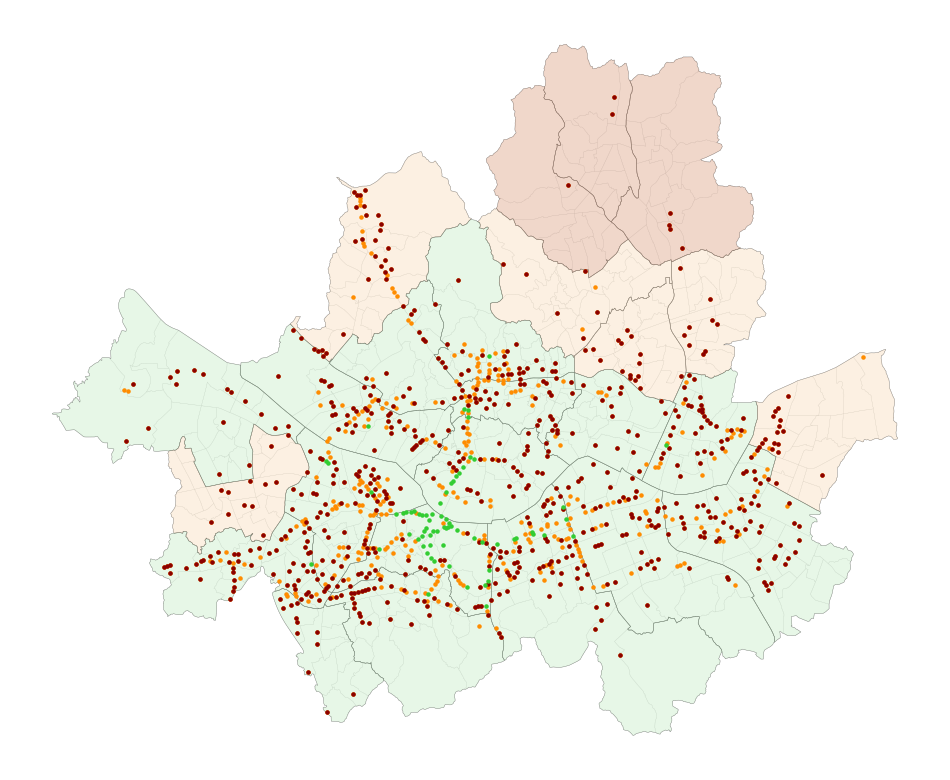

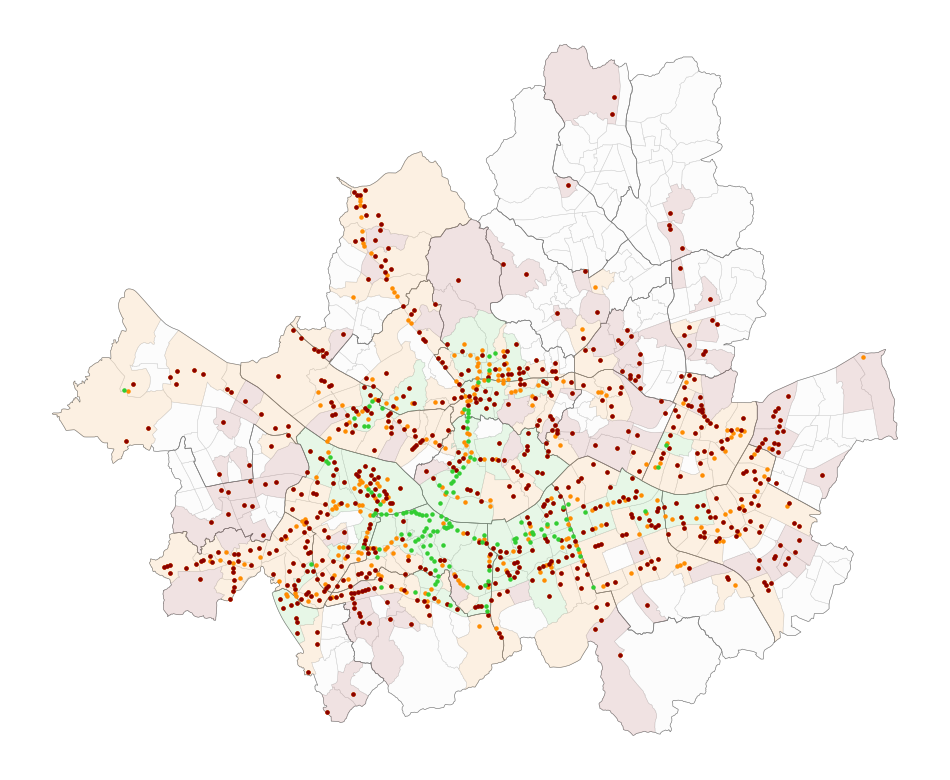

In [21]:
import matplotlib.colors as colors
import matplotlib.cm as cm


# plot nodes_gdf
cmap1 = cm.get_cmap('rainbow')

norm_fixed = colors.Normalize(vmin=0, vmax=22)
# nodes_gdf.plot(figsize=(10, 10), markersize=5, cmap=cmap1, norm=norm_fixed, legend=True)

fig, ax = plt.subplots(figsize=(12, 12))

submunicipalities_gdf.plot(ax=ax, color='lightgrey', alpha=0.05)
submunicipalities_gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.12)
municipalities_gdf.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.3)

municipalities_gdf[municipalities_gdf['unique_participants'] <= 5].plot(ax=ax, color='darkorange', edgecolor='none', alpha=0.1)
municipalities_gdf[municipalities_gdf['unique_participants'] == 1].plot(ax=ax, color='darkred', edgecolor='none', alpha=0.1)
municipalities_gdf[municipalities_gdf['unique_participants'] > 5].plot(ax=ax, color='limegreen', edgecolor='none', alpha=0.1)

nodes_gdf[nodes_gdf['unique_participants'] <= 5].plot(ax=ax, markersize=5, color='darkorange')
nodes_gdf[nodes_gdf['unique_participants'] == 1].plot(ax=ax, markersize=5, color='darkred')
nodes_gdf[nodes_gdf['unique_participants'] > 5].plot(ax=ax, markersize=5, color='limegreen')

ax.set_axis_off()


fig, ax = plt.subplots(figsize=(12, 12))

submunicipalities_gdf.plot(ax=ax, color='lightgrey', alpha=0.05)
submunicipalities_gdf.plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.3)
municipalities_gdf.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.45)

submunicipalities_gdf[    (submunicipalities_gdf['unique_participants'] <= 5) &
    (submunicipalities_gdf['unique_participants'] > 1)].plot(ax=ax, color='darkorange', edgecolor='none', alpha=0.1)
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] == 1].plot(ax=ax, color='darkred', edgecolor='none', alpha=0.1)
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] == 0].plot(ax=ax, color='white', edgecolor='none', alpha=0.0)
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] > 5].plot(ax=ax, color='limegreen', edgecolor='none', alpha=0.1)


nodes_gdf[nodes_gdf['unique_participants'] <= 3].plot(ax=ax, markersize=5, color='darkorange')
nodes_gdf[nodes_gdf['unique_participants'] == 1].plot(ax=ax, markersize=5, color='darkred')
nodes_gdf[nodes_gdf['unique_participants'] > 3].plot(ax=ax, markersize=5, color='limegreen')

ax.set_axis_off()

In [22]:
avg_participants_per_sub = (
    nodes_gdf.groupby('submuni_index')['unique_participants']
    .mean()
    .rename('avg_unique_participants')
)

submunicipalities_gdf = submunicipalities_gdf.join(avg_participants_per_sub, how='left')

In [23]:
avg_positions_per_sub = (
    nodes_gdf.groupby('submuni_index')['total_positions']
    .mean()
    .rename('avg_positions')
)

submunicipalities_gdf = submunicipalities_gdf.join(avg_positions_per_sub, how='left')

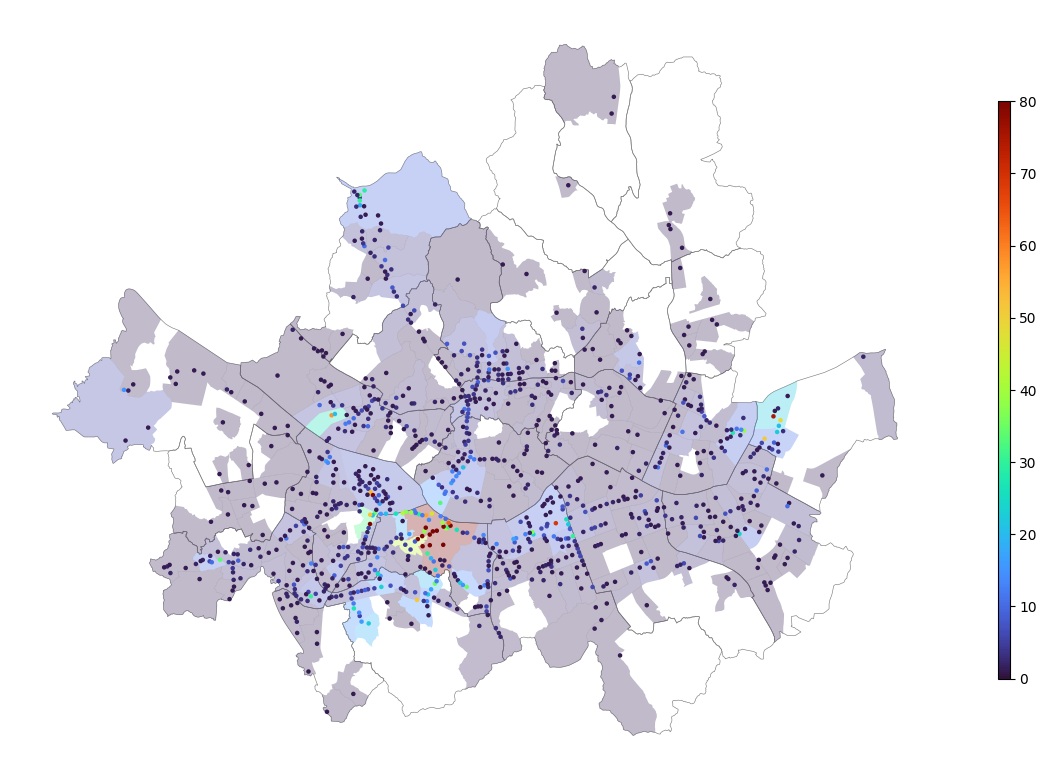

In [24]:



fig, ax = plt.subplots(figsize=(15, 15))

norm_fixed = colors.Normalize(vmin=0, vmax=500)
norm_fixed2 = colors.Normalize(vmin=0, vmax=50)
norm_fixed3 = colors.Normalize(vmin=0, vmax=80)

legend_kwds={
        'shrink': 0.5,       # scale the height
        'aspect': 50,        # controls thickness
        'alpha': 1,        # transparency
    }

legend_kwds2={
        'shrink': 0.5,       # scale the height
        'aspect': 50,        # controls thickness
        'alpha': 0.3,        # transparency
    }


# submunicipalities_gdf.plot(ax=ax, alpha=0.3, column='total_positions', legend=False, cmap='turbo', norm=norm_fixed, legend_kwds=legend_kwds)
# submunicipalities_gdf[submunicipalities_gdf['avg_positions'] <= 80].plot(
#     ax=ax,
#     alpha=0.4,
#     column='avg_positions',
#     legend=True,
#     color='darkred',
#     norm=norm_fixed3,
#     edgecolor='grey',
#     linewidth=0.2
# )

# submunicipalities_gdf[submunicipalities_gdf['avg_positions'] > 80].plot(
#     ax=ax,
#     alpha=0.4,
#     column='avg_positions',
#     legend=True,
#     color='limegreen',
#     norm=norm_fixed3,
#     edgecolor='grey',
#     linewidth=0.2
# )


submunicipalities_gdf[submunicipalities_gdf['avg_positions'] <= 5].plot(ax=ax, color='none', edgecolor='lightgrey', linewidth=0.12, alpha=1)
municipalities_gdf.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.45)
submunicipalities_gdf.plot(ax=ax, alpha=0.3, column='avg_positions', legend=False, cmap='turbo', norm=norm_fixed3, legend_kwds=legend_kwds2)



nodes_gdf.plot(ax=ax, alpha=1, column='total_positions', legend=True, cmap='turbo', markersize=5, norm=norm_fixed3, legend_kwds=legend_kwds)

ax.set_axis_off()

In [25]:
from shapely.ops import nearest_points


nodes_grouped = nodes_gdf.copy()
positions_seoul_grouped = positions_with_nodes_all.copy()

def point_inside(pt, poly):
    if poly is None:
        return pt
    if poly.contains(pt):
        return pt
    return nearest_points(pt, poly)[1]


def weighted_point(pts, weights=None, poly=None):
    xs = np.array([p.x for p in pts], dtype=float)
    ys = np.array([p.y for p in pts], dtype=float)
    if weights is None:
        wx, wy = xs.mean(), ys.mean()
    else:
        w = np.array(weights, dtype=float)
        w[~np.isfinite(w)] = 0.0
        if w.sum() == 0:
            wx, wy = xs.mean(), ys.mean()
        else:
            wx = np.average(xs, weights=w)
            wy = np.average(ys, weights=w)
    return point_inside(Point(float(wx), float(wy)), poly)

muni_field = 'unique_participants'
submuni_field = 'avg_positions'

# AGGREGATION PIPELINE
next_node_id = int(nodes_grouped['node_id'].max()) + 1
id_map = {}
removed_nodes = set()
agg_rows = []


# ---------- RULES 1 & 2 over MUNICIPALITIES ----------
'''
Rule 1: If a municipality has only one node, keep that node.
Rule 2: If a municipality has less than 5 unique participants, aggregate the nodes into a single 'municipality' node.
'''
for m_idx, df_m in nodes_grouped.groupby('muni_index', dropna=False):
    node_ids = df_m['node_id'].tolist()
    if not node_ids:
        continue

    # Rule 1
    if len(node_ids) == 1:
        nid = node_ids[0]
        nodes_grouped.loc[nodes_grouped['node_id'] == nid, 'node_type'] = 'intersection_municipality'
        id_map.setdefault(nid, nid)
        print(f"Keeping single node {nid} in municipality {m_idx}")
        continue

    # Rule 2
    unique_participants = municipalities_gdf.loc[m_idx, 'unique_participants']
    if unique_participants < 5:
        poly = municipalities_gdf.loc[m_idx, 'geometry']
        pts = df_m.geometry.tolist()
        weights = df_m['unique_participants'].to_numpy()
        new_pt = weighted_point(pts, weights=weights, poly=poly)

        new_row = {
            'node_id': next_node_id,
            'geometry': new_pt,  
            'total_positions': df_m['total_positions'].sum(),
            'unique_participants': np.nan,
            'node_type': 'municipality',
            'muni_index': m_idx,
            'submuni_index': np.nan
        }
        for nid in node_ids:
            id_map[nid] = next_node_id
            removed_nodes.add(nid)
        agg_rows.append(new_row)
        next_node_id += 1

    print(f"Keeping {len(node_ids)} nodes in municipality {m_idx} with {unique_participants} unique participants")

remaining = nodes_grouped[nodes_grouped['node_type'].isna() & (~nodes_grouped['node_id'].isin(removed_nodes))].copy() # Remaining after municipalities


# ---------- RULES 3–6 over SUBMUNICIPALITIES ----------
'''
Rule 3: If a submunicipality has only one node, keep that node.
Rule 4: If a submunicipality has on average less than 14 total visits per node, aggregate the nodes into a single 'submunicipality' node.
Rule 5: If a submunicipality has on average less than or equal to 80 total visits per node, keep the current intersection nodes.
Rule 6: If a submunicipality has on average more than 80 total visits per node, keep the current intersection nodes, but give them a different type for later.
'''

# Global cache of main-geometry -> node_id that will exist in the final output --CHECK
global_main_by_wkt = {}

def register_main_node(geom, node_id):
    global_main_by_wkt[geom.wkt] = node_id


for s_idx, df_s in remaining.groupby('submuni_index', dropna=False):
    node_ids = df_s['node_id'].tolist()
    if not node_ids:
        continue

    poly = submunicipalities_gdf.loc[s_idx, 'geometry']

    # Rule 3
    if len(node_ids) == 1:
        nid = node_ids[0]
        remaining.loc[remaining['node_id'] == nid, 'node_type'] = 'intersection_submunicipality'
        id_map.setdefault(nid, nid)
        continue

    avg_positions = submunicipalities_gdf.loc[s_idx, 'avg_positions']

    # Rule 4
    if avg_positions < 14:
        pts = df_s.geometry.tolist()
        weights = df_s['total_positions'].to_numpy()
        new_pt = weighted_point(pts, weights=weights, poly=poly)
        new_row = {
            'node_id': next_node_id,
            'geometry': new_pt,
            'total_positions': df_s['total_positions'].sum(),
            'unique_participants': np.nan,
            'node_type': 'submunicipality',
            'muni_index': df_s['muni_index'].tolist()[0],
            'submuni_index': s_idx
        }
        for nid in node_ids:
            id_map[nid] = next_node_id
            removed_nodes.add(nid)
        agg_rows.append(new_row)
        next_node_id += 1
        continue

    # Rule 5

    if avg_positions <= 80:
        # 1) Get MAIN intersections inside this submunicipality (fallback: all mains if none inside)
        main_in_poly = intersections_gdf[intersections_gdf.within(poly)]
        if main_in_poly.empty:
            main_geoms = list(intersections_gdf.geometry)   # fallback: all main intersections
        else:
            main_geoms = list(main_in_poly.geometry)

        if len(main_geoms) == 0:
            # extreme fallback: no mains at all -> just keep current nodes
            remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'intersection'
            for nid in node_ids:
                id_map.setdefault(nid, nid)
            continue

        main_tree = STRtree(main_geoms)

        # 2) Map each combined node in this submunicipality to its nearest MAIN
        grouped_by_main_wkt = {}   # main_wkt -> {"geom": main_geom, "nids": [old_ids]}
        for nid in node_ids:
            old_geom = remaining.loc[remaining["node_id"] == nid, "geometry"].iloc[0]
            nearest_idx = int(main_tree.nearest(old_geom))
            main_geom = main_geoms[nearest_idx]
            key = main_geom.wkt
            if key not in grouped_by_main_wkt:
                grouped_by_main_wkt[key] = {"geom": main_geom, "nids": []}
            grouped_by_main_wkt[key]["nids"].append(nid)

        # 3) Reuse existing rows at MAIN intersections if possible; create a new row if not
        existing_by_wkt = {g.wkt: nid for nid, g in zip(remaining["node_id"], remaining["geometry"])}

        for main_wkt, pack in grouped_by_main_wkt.items():
            main_geom = pack["geom"]
            group_nids = pack["nids"]

            if main_wkt in existing_by_wkt:
                # Reuse the existing node already at this MAIN
                new_nid = int(existing_by_wkt[main_wkt])
                remaining.loc[remaining["node_id"] == new_nid, "node_type"] = "intersection"
            else:
                # Create one new node row for this MAIN
                new_nid = next_node_id
                next_node_id += 1
                agg_rows.append({
                    "node_id": new_nid,
                    "geometry": main_geom,
                    "total_positions": remaining[remaining["node_id"].isin(group_nids)]["total_positions"].sum(),
                    "unique_participants": np.nan,
                    "node_type": "intersection",
                    "muni_index": df_s["muni_index"].iloc[0],
                    "submuni_index": s_idx
                })
                existing_by_wkt[main_wkt] = new_nid

            # Remap all old node_ids in this group to the chosen MAIN node_id
            for old_id in group_nids:
                if old_id != new_nid:
                    id_map[old_id] = new_nid
                    removed_nodes.add(old_id)

        # mark the originals as processed (they’ll be dropped later when building parts)
        remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'intersection'
        continue


    # main_in_poly = intersections_gdf[intersections_gdf.within(poly)]
    # main_geoms = list(main_in_poly.geometry)
    # main_tree = STRtree(main_geoms)

    # # map each combined node in this submunicipality to nearest MAIN node
    # grouped_by_main_wkt = {}   # main_wkt -> list of original node_ids to collapse
    # for nid in node_ids:
    #     old_geom = remaining.loc[remaining["node_id"] == nid, "geometry"].iloc[0]
    #     nearest_idx = int(main_tree.nearest(old_geom))
    #     main_geom = main_geoms[nearest_idx]
    #     key = main_geom.wkt
    #     grouped_by_main_wkt.setdefault(key, {"geom": main_geom, "nids": []})
    #     grouped_by_main_wkt[key]["nids"].append(nid)

    # if avg_positions <= 80:
    #     remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'intersection'
    #     for nid in node_ids:
    #         id_map.setdefault(nid, nid)
    #     continue


    # Rule 6
    if avg_positions > 80:
        # High-activity submunicipality: keep ALL nodes (main + local) as-is,
        # just tag them with a special type so we know they're "detailed"
        remaining.loc[remaining['node_id'].isin(node_ids), 'node_type'] = 'submunicipality_detailed'
        for nid in node_ids:
            id_map.setdefault(nid, nid)  # no remap; keep IDs unchanged
        continue

Keeping 19 nodes in municipality 0.0 with 3 unique participants
Keeping 71 nodes in municipality 1.0 with 12 unique participants
Keeping 68 nodes in municipality 2.0 with 17 unique participants
Keeping 99 nodes in municipality 3.0 with 21 unique participants
Keeping 49 nodes in municipality 4.0 with 13 unique participants
Keeping 105 nodes in municipality 5.0 with 22 unique participants
Keeping 110 nodes in municipality 6.0 with 20 unique participants
Keeping 14 nodes in municipality 7.0 with 9 unique participants
Keeping 68 nodes in municipality 8.0 with 11 unique participants
Keeping 19 nodes in municipality 9.0 with 8 unique participants
Keeping 13 nodes in municipality 10.0 with 3 unique participants
Keeping 65 nodes in municipality 11.0 with 15 unique participants
Keeping 24 nodes in municipality 12.0 with 12 unique participants
Keeping 39 nodes in municipality 13.0 with 4 unique participants
Keeping 4 nodes in municipality 14.0 with 1 unique participants
Keeping 2 nodes in munici

In [26]:
# ---------- BUILD UPDATED NODES ----------
processed1 = nodes_grouped[(nodes_grouped['node_type'].notna()) & (~nodes_grouped['node_id'].isin(removed_nodes))].copy()
processed2 = remaining[~remaining['node_id'].isin(removed_nodes)].copy()

parts = [processed1, processed2]

if agg_rows:
    agg_df = pd.DataFrame(agg_rows)
    agg_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs=nodes_grouped.crs)
    parts.append(agg_gdf)

nodes_grouped = pd.concat(parts, ignore_index=True)
nodes_grouped = gpd.GeoDataFrame(nodes_grouped, geometry='geometry', crs=nodes_grouped.crs)


def remap_node_id(val):
    if pd.isna(val):
        return val
    try:
        return id_map.get(int(val), int(val))
    except Exception:
        return val

positions_seoul_grouped['node_id'] = positions_seoul_grouped['node_id'].apply(remap_node_id)

missing_after_first_remap = positions_seoul_grouped.loc[
    positions_seoul_grouped['node_id'].isna(), ['id_participant','merged_datetime']
]
print(f"[CHECK] Missing after first remap: {len(missing_after_first_remap)}")


[CHECK] Missing after first remap: 0


In [27]:
old_ids_in_order = nodes_grouped['node_id'].drop_duplicates().tolist()
id_remap = {old: new for new, old in enumerate(old_ids_in_order)}

nodes_grouped['node_id_old'] = nodes_grouped['node_id']
nodes_grouped['node_id'] = nodes_grouped['node_id'].map(id_remap).astype(int)
positions_seoul_grouped['node_id_old'] = positions_seoul_grouped['node_id']

def map_pos_id(x):
    if pd.isna(x):
        return pd.NA
    try:
        return id_remap.get(int(x), pd.NA)
    except Exception:
        return pd.NA

positions_seoul_grouped['node_id'] = positions_seoul_grouped['node_id'].apply(map_pos_id).astype('Int64')

unmapped_ids = set(
    positions_seoul_grouped.loc[positions_seoul_grouped['node_id'].isna(),'node_id_old']
    .dropna().astype(int).unique()
)
print(f"[CHECK] Unmapped old ids after renumber: {len(unmapped_ids)} -> {sorted(list(unmapped_ids))[:10]} ...")
present_final_ids = set(nodes_grouped['node_id_old'].astype(int).unique())
print(f"[CHECK] Any unmapped olds not in final nodes? {bool(unmapped_ids - present_final_ids)}")

[CHECK] Unmapped old ids after renumber: 1 -> [np.int64(624)] ...
[CHECK] Any unmapped olds not in final nodes? True


In [28]:
# QUICK FIX ---- CHECK
# assign any NaN node_ids to the nearest MAIN node (fallback: any node) ---

# which node_types count as "main" in your final nodes table
MAIN_TYPES = {"intersection", "intersection_municipality", "intersection_submunicipality"}

na_mask = positions_seoul_grouped["node_id"].isna()
n_missing_before = int(na_mask.sum())
print(f"[quick-fix] positions with NaN node_id before fix: {n_missing_before}")

if n_missing_before > 0:
    # 1) try to use only main-type nodes
    mains = nodes_grouped[nodes_grouped["node_type"].isin(MAIN_TYPES)].copy()

    # fallback: if you somehow have no explicit main nodes tagged, use all nodes
    if mains.empty:
        print("[quick-fix] No nodes with main types found; falling back to ALL nodes.")
        mains = nodes_grouped.copy()

    # Build a spatial index for nearest lookups
    main_geoms = list(mains.geometry)
    main_ids   = list(mains["node_id"].astype(int))
    from shapely.strtree import STRtree
    tree = STRtree(main_geoms)

    # map geometry -> node_id (use WKT key because STRtree returns geometry objects)
    wkt2id = {geom.wkt: nid for geom, nid in zip(main_geoms, main_ids)}

    # Assign nearest main node_id to each NaN position
    for idx, pt in positions_seoul_grouped.loc[na_mask, "geometry"].items():
        nearest_geom_id = tree.nearest(pt)
        nearest_geom = main_geoms[nearest_geom_id]
        new_id = wkt2id[nearest_geom.wkt]
        positions_seoul_grouped.at[idx, "node_id"] = new_id

    # keep it as nullable int (Int64) going forward
    positions_seoul_grouped["node_id"] = positions_seoul_grouped["node_id"].astype("Int64")

n_missing_after = int(positions_seoul_grouped["node_id"].isna().sum())
print(f"[quick-fix] positions with NaN node_id after fix: {n_missing_after}")

[quick-fix] positions with NaN node_id before fix: 44
[quick-fix] positions with NaN node_id after fix: 0


In [29]:
# final checks

nodes_set = set(nodes_grouped['node_id'].astype(int).unique())
pos_set   = set(positions_seoul_grouped['node_id'].dropna().astype(int).unique())

missing_in_nodes = pos_set - nodes_set
if missing_in_nodes:
    print("Warning: some remapped position node_ids not present in nodes_grouped:", sorted(missing_in_nodes))

# Check contiguous 0..N-1
max_id = nodes_grouped['node_id'].max()
expected = set(range(max_id + 1))
if nodes_set != expected:
    print("Warning: node IDs are not perfectly contiguous:", sorted(nodes_set ^ expected))

print("Renumbered nodes from", len(old_ids_in_order), "unique IDs to", max_id + 1, "sequential IDs (0..N-1).")

Renumbered nodes from 271 unique IDs to 271 sequential IDs (0..N-1).


In [30]:
# creating a node gdf with the node coordinates and id
nodes = gpd.GeoDataFrame(
    nodes_grouped,
    geometry= gpd.points_from_xy(
        nodes_grouped.geometry.x, 
        nodes_grouped.geometry.y
    ),
    crs=nodes_grouped.crs
)

# creating node x and node y fields
nodes['node_x'] = nodes.geometry.x
nodes['node_y'] = nodes.geometry.y

nodes.drop(columns=['node_id_old'], inplace=True)

In [31]:
#updating the speed field
positions_seoul_grouped['prev_lat'] = positions_seoul_grouped.groupby('id_participant')['latitude'].shift()
positions_seoul_grouped['prev_lon'] = positions_seoul_grouped.groupby('id_participant')['longitude'].shift()
positions_seoul_grouped['prev_time'] = positions_seoul_grouped.groupby('id_participant')['merged_datetime'].shift()
positions_seoul_grouped['time_diff'] = (positions_seoul_grouped['merged_datetime'] - positions_seoul_grouped['prev_time']).dt.total_seconds()
positions_seoul_grouped['geo_distance'] = positions_seoul_grouped.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)
positions_seoul_grouped['speed'] = positions_seoul_grouped['geo_distance'] / positions_seoul_grouped['time_diff']

# set nan speed values to 0
positions_seoul_grouped['speed'].fillna(0, inplace=True)

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\875610752.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  positions_seoul_grouped['speed'].fillna(0, inplace=True)


In [32]:
positions_links = positions_seoul_grouped[['id_participant','merged_datetime', 'node_id', 'speed']].copy()

positions_links['node_id'] = positions_links['node_id'].astype(int)
positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift(1)
positions_links = positions_links.dropna(subset=['prev_node_id'])
positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)
positions_links['id_participant'] = positions_links["id_participant"].str.extract(r'arda(\d+)').astype(int)

In [33]:
nodes.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_4_intersections/nodes_detailed.csv"))
positions_links.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_4_intersections/positions_links_detailed.csv"))

In [34]:
nodes.to_file(os.path.join(base_dir,"shapefiles/_network_parts_4_intersections/nodes_detailed.shp"))
# positions_seoul.to_file(
#     os.path.join(base_dir, 'shapefiles/_network_parts_4_intersections/grouped_positions_seoul.shp'),
#     driver='ESRI Shapefile'
# )

C:\Users\Michele\AppData\Local\Temp\ipykernel_15480\3646069419.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes.to_file(os.path.join(base_dir,"shapefiles/_network_parts_4_intersections/nodes_detailed.shp"))
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_positions' to 'total_posi'
  ogr_write(
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'unique_participants' to 'unique_par'
  ogr_write(
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'submuni_index' to 'submuni_in'
  ogr_write(


In [ ]:

# node_id_counter = 0
# node_records = []
# positions_node_ids = {}

# # submunicipalities > 1000 positions
# high_submuni_idx = submunicipalities_gdf[submunicipalities_gdf['total_positions'] > 1000].index
# high_positions = positions_gdf[positions_gdf['submuni_index'].isin(high_submuni_idx)].copy()

# intersection_tree = STRtree(intersections_gdf.geometry)
# intersection_geoms = list(intersections_gdf.geometry)

# used_intersections = {}

# for idx, row in high_positions.iterrows():
#     pt = row.geometry
#     nearest_idx = intersection_tree.nearest(pt)
#     nearest_geom = intersection_geoms[int(nearest_idx)]
#     geom_key = nearest_geom.wkt

#     if geom_key not in used_intersections:
#         used_intersections[geom_key] = node_id_counter
#         node_records.append({
#             'node_id': node_id_counter,
#             'geometry': nearest_geom,
#             'source': 'intersection'    #CHECK
#         })
#         node_id_counter += 1

#     positions_node_ids[idx] = used_intersections[geom_key]


# # submunicipalities > 50 positions
# mid_submuni_idx = submunicipalities_gdf[
#     (submunicipalities_gdf['total_positions_sub'] > 50) & 
#     (submunicipalities_gdf['total_positions_sub'] <= 1000)
# ].index

# mid_positions = positions_gdf[positions_gdf['submuni_index'].isin(mid_submuni_idx)].copy()

# mid_submuni_node_ids = {}

# for idx in mid_submuni_idx:
#     centroid = submunicipalities_gdf.loc[idx, 'geometry'].centroid
#     mid_submuni_node_ids[idx] = node_id_counter

#     node_records.append({
#         'node_id': node_id_counter,
#         'geometry': centroid,
#         'source': 'submunicipality' #CHECK
#     })
#     node_id_counter += 1

# for idx, row in mid_positions.iterrows():
#     positions_node_ids[idx] = mid_submuni_node_ids[row['submuni_index']]




C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('rainbow')
C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:18: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  municipalities_gdf[municipalities_gdf['total_positions'] == 0].plot(ax=ax1_muni, color='lightgrey', edgecolor='black')


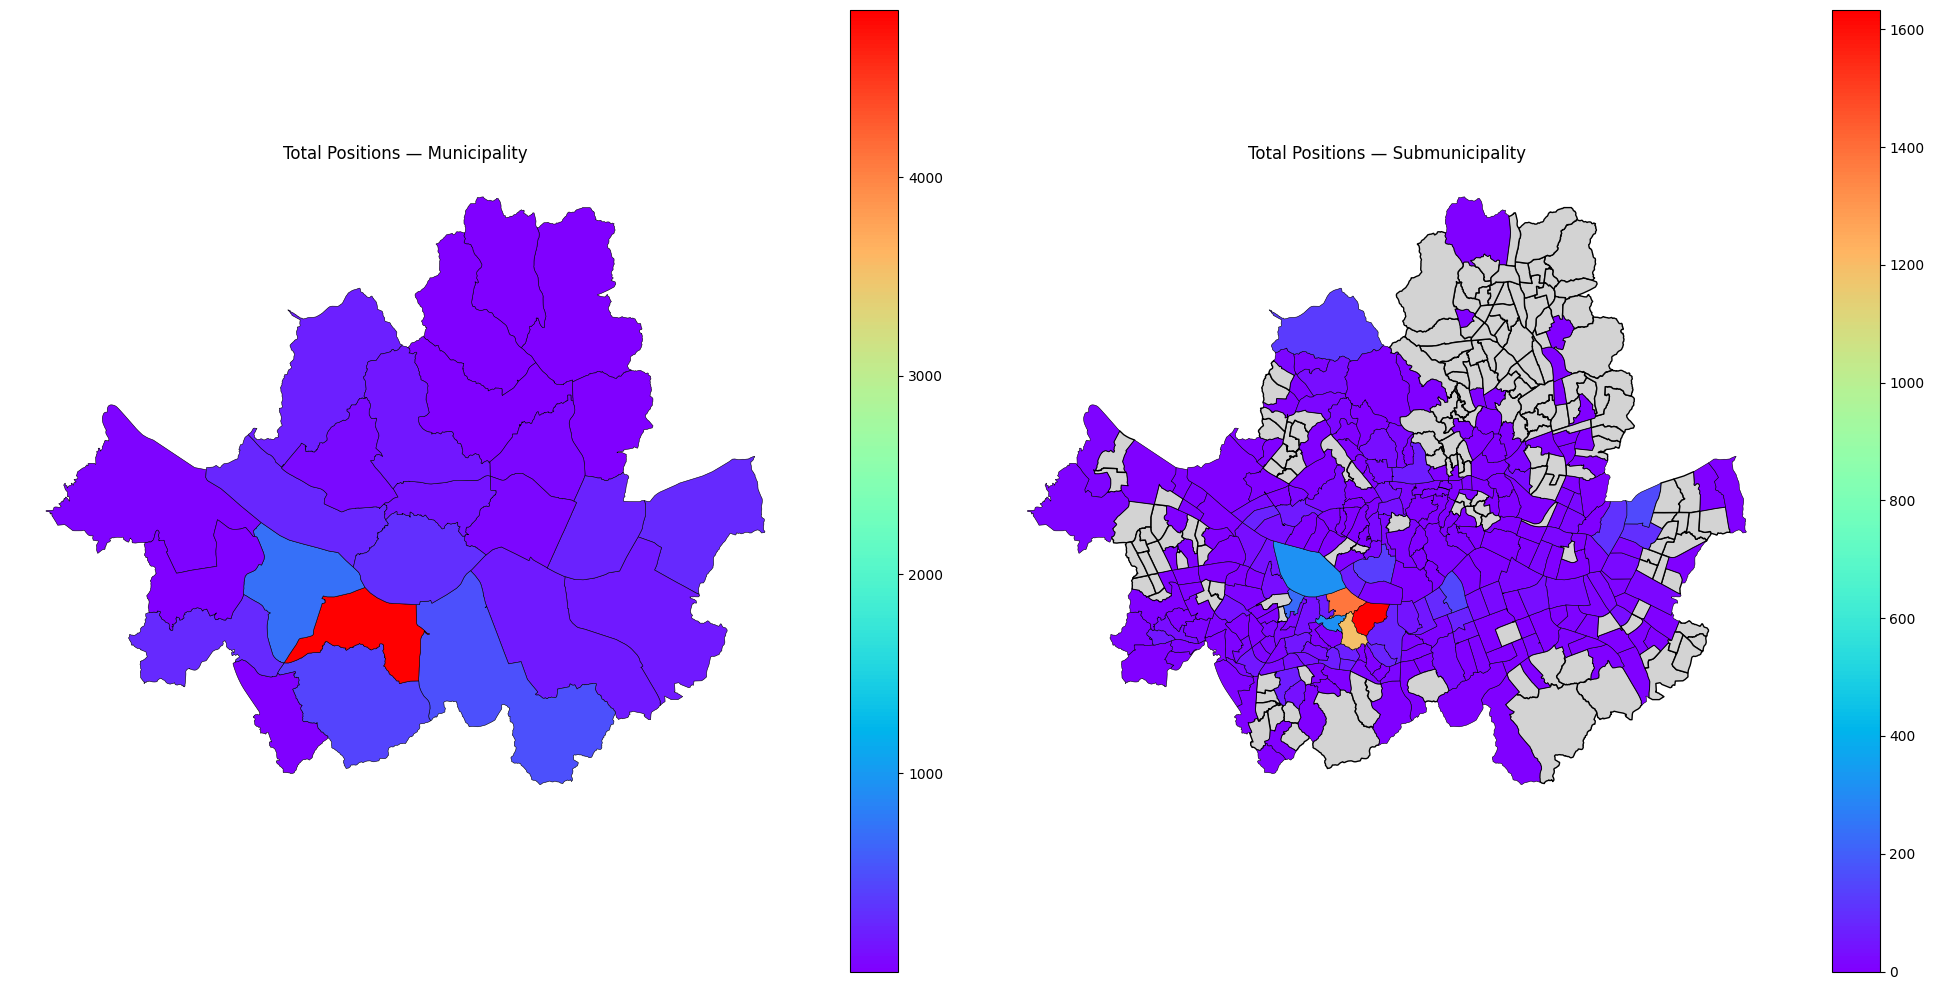

C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('rainbow')
C:\Users\Michele\AppData\Local\Temp\ipykernel_13236\3838024822.py:46: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  municipalities_gdf[municipalities_gdf['unique_participants'] == 0].plot(ax=ax2_muni, color='lightgrey', edgecolor='black')


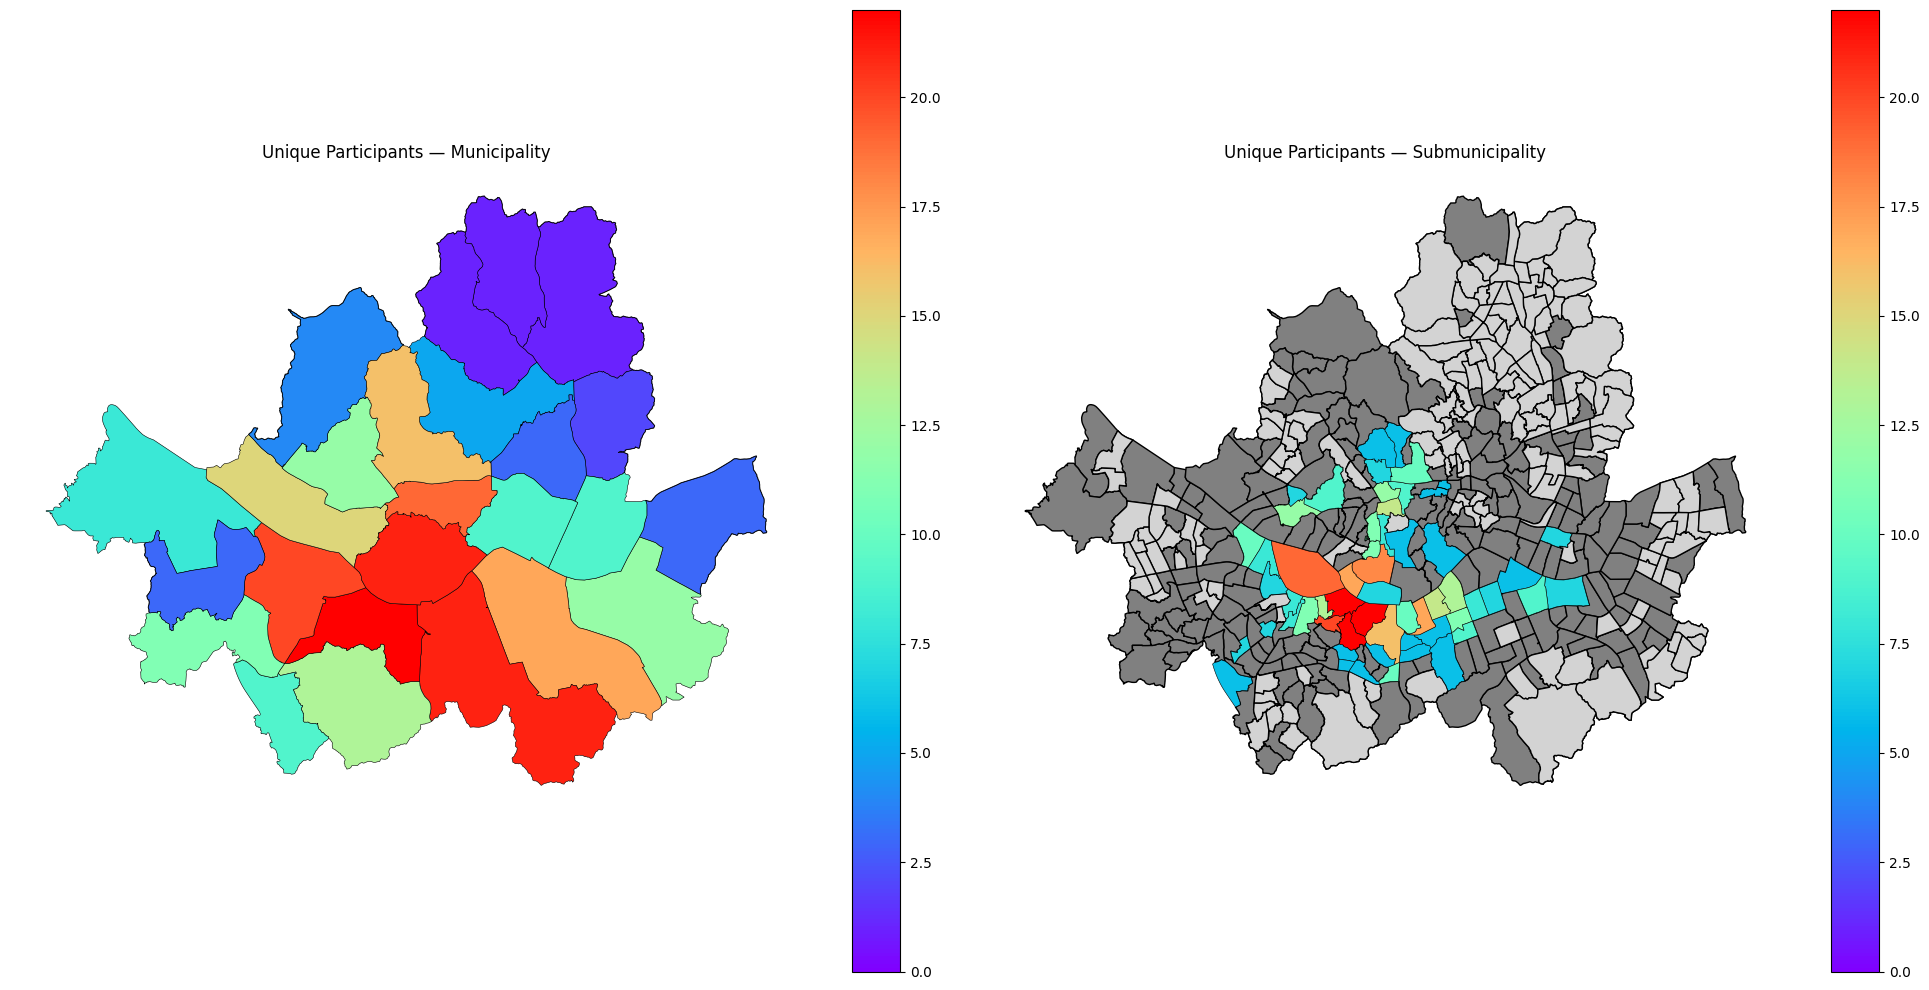

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

# ----------------------------
# PLOT 1: Total Positions
# ----------------------------
fig1, (ax1_muni, ax1_submuni) = plt.subplots(1, 2, figsize=(20, 10))
cmap1 = cm.get_cmap('rainbow')

# Normalize based on non-zero values
norm_muni1 = colors.Normalize(vmin=municipalities_gdf[municipalities_gdf['total_positions'] >= 0]['total_positions'].min(),
                              vmax=municipalities_gdf['total_positions'].max())
norm_sub1 = colors.Normalize(vmin=submunicipalities_gdf[submunicipalities_gdf['total_positions'] >= 0]['total_positions'].min(),
                             vmax=submunicipalities_gdf['total_positions'].max())

# Municipalities
municipalities_gdf[municipalities_gdf['total_positions'] == 0].plot(ax=ax1_muni, color='lightgrey', edgecolor='black')
municipalities_gdf[municipalities_gdf['total_positions'] > 0].plot(
    column='total_positions', cmap=cmap1, linewidth=0.4, ax=ax1_muni, edgecolor='black', norm=norm_muni1, legend=True
)
ax1_muni.set_title('Total Positions — Municipality')
ax1_muni.axis('off')

# Submunicipalities
submunicipalities_gdf[submunicipalities_gdf['total_positions'] == 0].plot(ax=ax1_submuni, color='lightgrey', edgecolor='black')
submunicipalities_gdf[submunicipalities_gdf['total_positions'] > 0].plot(
    column='total_positions', cmap=cmap1, linewidth=0.4, ax=ax1_submuni, edgecolor='black', norm=norm_sub1, legend=True
)
ax1_submuni.set_title('Total Positions — Submunicipality')
ax1_submuni.axis('off')

plt.tight_layout()
plt.show()

# ----------------------------
# PLOT 2: Unique Participants
# ----------------------------
fig2, (ax2_muni, ax2_submuni) = plt.subplots(1, 2, figsize=(20, 10))
cmap2 = cm.get_cmap('rainbow')
norm_fixed = colors.Normalize(vmin=0, vmax=22)

# Municipalities

municipalities_gdf[municipalities_gdf['unique_participants'] < 5].plot(ax=ax2_muni, color='grey', edgecolor='black')
municipalities_gdf[municipalities_gdf['unique_participants'] == 0].plot(ax=ax2_muni, color='lightgrey', edgecolor='black')
municipalities_gdf[municipalities_gdf['unique_participants'] > 0].plot(
    column='unique_participants', cmap=cmap2, linewidth=0.4, ax=ax2_muni, edgecolor='black', norm=norm_fixed, legend=True
)
ax2_muni.set_title('Unique Participants — Municipality')
ax2_muni.axis('off')

# Submunicipalities
# submunicipalities_gdf[submunicipalities_gdf['unique_participants'] <= 5].plot(ax=ax2_submuni, color='grey', edgecolor='black')
submunicipalities_gdf[submunicipalities_gdf['unique_participants'] == 0].plot(ax=ax2_submuni, color='lightgrey', edgecolor='black')

submunicipalities_gdf[submunicipalities_gdf['unique_participants'] > 0].plot(
    column='unique_participants', cmap=cmap2, linewidth=0.4, ax=ax2_submuni, edgecolor='black', norm=norm_fixed, legend=True
)
ax2_submuni.set_title('Unique Participants — Submunicipality')
ax2_submuni.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
neighborhood_extents_gdf = gpd.read_file(os.path.join(base_dir, 'shapefiles/crop/crop_neighborhood.shp'))
neighborhood_extents_gdf = neighborhood_extents_gdf.to_crs(buildings.crs)

In [ ]:
extents_gdf["is_valid"] = extents_gdf.is_valid

In [ ]:
# creating a GeoDataFrame from the filtered points
positions_gdf = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df.longitude, filtered_df.latitude), crs='EPSG:4326')
positions_gdf = positions_gdf.to_crs(buildings.crs)

In [ ]:
# marking positions that are outside Seoul's extents
# initializing the node id field
positions_gdf['node_id'] = np.nan

# function to check if a point is inside the extents
positions_gdf["in_Seoul"] = positions_gdf.geometry.within(extents_gdf.union_all())
positions_gdf["in_Neighborhood"] = positions_gdf.geometry.within(neighborhood_extents_gdf.union_all())

positions_seoul = positions_gdf[positions_gdf['in_Seoul'] == True]


In [ ]:
# keeping only records outside Neighborhood every 30 minutes
outside_neighborhood_records = []
interval_seconds = 1800 

for pid, group in positions_gdf[positions_gdf["in_Seoul"] & ~positions_gdf["in_Neighborhood"]].groupby("id_participant"):
    group = group.sort_values("merged_datetime")
    last_time = None

    for _, row in group.iterrows():
        if last_time is None or (row['merged_datetime'] - last_time).total_seconds() >= interval_seconds:
            row_copy = row.copy()
            row_copy["node_id"] = -1  
            outside_neighborhood_records.append(row_copy)
            last_time = row['merged_datetime']

outside_neighborhood_df = pd.DataFrame(outside_neighborhood_records)

positions_seoul = pd.concat([
    positions_gdf[positions_gdf["in_Neighborhood"]],  # inside
    outside_neighborhood_df                           # outside (sampled)
]).sort_values(["id_participant", "merged_datetime"]).reset_index(drop=True)

In [ ]:
print('Max id:', positions_gdf["node_id"].max())
print('Number of node ids:', len(positions_gdf["node_id"].unique()))

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
extents_gdf.boundary.plot(ax=ax, color='red')  # Plot extents
positions_seoul[~positions_seoul['in_Neighborhood']].plot(ax=ax, color='blue', alpha=0.5, markersize=2)  # Plot points
positions_seoul[positions_seoul['in_Neighborhood']].plot(ax=ax, color='red', alpha=0.5, markersize=2)  # Plot points

ax.set_axis_off()  

plt.show()

In [ ]:
positions_seoul = positions_seoul.sort_values(by=['id_participant', 'merged_datetime'])
positions_seoul.loc[~positions_seoul['in_Neighborhood'], 'node_id'] = -1

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

In [ ]:
# Dividing the points outside Seoul into eight node IDs based on their directional quadrant:
# 1: NN, 2: NE, 3: EE, 4: SE, 5: SS, 6: SW, 7: WW, 8: NW

neighborhood_center = neighborhood_extents_gdf.union_all().centroid
center_x, center_y = neighborhood_center.x, neighborhood_center.y

def assign_cardinal_node_id(row):
    if row['node_id'] != -1:
        return row['node_id']
    
    dx = row.geometry.x - center_x  # Longitude difference
    dy = row.geometry.y - center_y  # Latitude difference

    # Angle in coordinates (0° = East, 90° = North)
    angle = np.degrees(np.arctan2(dy, dx)) 
    if angle < 0:
        angle += 360  # Convert angle to a 0-360° scale

    # Assigning node_id based on 45-degree sectors
    if 0 <= angle < 22.5 or angle >= 337.5:
        return 1  # EE (East)
    elif 22.5 <= angle < 67.5:
        return 2  # NE (North-East)
    elif 67.5 <= angle < 112.5:
        return 3  # NN (North)
    elif 112.5 <= angle < 157.5:
        return 4  # NW (North-West)
    elif 157.5 <= angle < 202.5:
        return 5  # WW (West)
    elif 202.5 <= angle < 247.5:
        return 6  # SW (South-West)
    elif 247.5 <= angle < 292.5:
        return 7  # SS (South)
    elif 292.5 <= angle < 337.5:
        return 8  # SE (South-East)

positions_seoul["node_id"] = positions_seoul.apply(assign_cardinal_node_id, axis=1)


In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

In [ ]:
from matplotlib.patches import Wedge
fig, ax = plt.subplots(figsize=(8, 8))

# Define node colors (Same as points, but will use lower opacity for background)
node_colors = {
    1: "blue",
    2: "green",
    3: "purple",
    4: "orange",
    5: "brown",
    6: "pink",
    7: "gray",
    8: "black",
}

# Define max radius (adjustable based on data range)
max_radius = max(
    positions_seoul.geometry.x.max() - center_x,
    positions_seoul.geometry.y.max() - center_y
) * 1.2  # Scale up to ensure full coverage

# **Step 1: Add Transparent Background Slices**
for node_id, color in node_colors.items():
    start_angle = (node_id - 1) * 45 - 22.5  # Each slice is 45 degrees
    end_angle = node_id * 45 - 22.5

    # Add the Wedge (Pie Slice) to represent the quadrant
    wedge = Wedge(
        (center_x, center_y), max_radius, start_angle, end_angle,
        color=color, alpha=0.05, edgecolor="none", label=f"Quadrant {node_id}"
    )
    ax.add_patch(wedge)

# **Step 2: Overlay Points with Full Opacity**
for node_id, color in node_colors.items():
    positions_seoul[positions_seoul["node_id"] == node_id].plot(
        ax=ax, color=color, markersize=5, label=f"Node {node_id}"
    )

# Plot Seoul boundary
neighborhood_extents_gdf.boundary.plot(ax=ax, color='red', linewidth=0.3, label="Seoul Extents")

# Plot NaN node_id points in light grey
positions_seoul[positions_seoul["in_Seoul"]].plot(ax=ax, color='grey', markersize=1.5, label="Unknown (NaN)")

# **Step 3: Adjust Map Limits**
minx, miny, maxx, maxy = neighborhood_extents_gdf.total_bounds
x_margin = (maxx - minx) * 1
y_margin = (maxy - miny) * 1

ax.set_xlim(minx - x_margin, maxx + x_margin)
ax.set_ylim(miny - y_margin, maxy + y_margin)

# **Step 4: Final Adjustments**
#plt.legend()
plt.gca().set_aspect('equal')  # Keep the proportions correct
plt.show()

In [ ]:
# manually fixing a location with a wrong value

target_timestamp = "2023-11-15 10:13:59.690000+09:00"
target_participant = 'arda21'

matching_records = positions_seoul[
    (positions_seoul["id_participant"] == target_participant) &
    (positions_seoul["timestamp"] == target_timestamp)
]

if len(matching_records) == 1:
    # Modify the location attribute (set to NaN or another value)
    positions_seoul.loc[
        (positions_seoul["id_participant"] == target_participant) &
        (positions_seoul["timestamp"] == target_timestamp),
        "location"
    ] = np.nan

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

# __Creating Nodes__

In [ ]:
import rasterio
from rasterio.sample import sample_gen

In [ ]:
positions_seoul['altitude'] = np.where(positions_seoul['ts_altitude'].notna(), positions_seoul['ts_altitude'], positions_seoul['ws_altitude'])
positions_seoul['accuracy_horizontal'] = np.where(positions_seoul['ts_location_accuracy_horizontal'].notna(), positions_seoul['ts_location_accuracy_horizontal'], positions_seoul['ws_location_accuracy_horizontal'])
positions_seoul['accuracy_vertical'] = np.where(positions_seoul['ts_location_accuracy_vertical'].notna(), positions_seoul['ts_location_accuracy_vertical'], positions_seoul['ws_location_accuracy_vertical'])

positions_seoul['altitude'] = positions_seoul['altitude'].astype(float)
positions_seoul['accuracy_horizontal'] = positions_seoul['accuracy_horizontal'].astype(float)
positions_seoul['accuracy_vertical'] = positions_seoul['accuracy_vertical'].astype(float)

In [ ]:
# import terrain tiff file

terrain_tiff_path = os.path.join(base_dir, 'Data/GIS data/Terrain/dtm_90_cropped_proj.tif')

with rasterio.open(terrain_tiff_path) as src:
    # Sample the terrain data at the coordinates of the points
    coords = [(x, y) for x, y in zip(positions_seoul.geometry.x, positions_seoul.geometry.y)]
    terrain_heights = list(src.sample(coords))
    terrain_heights = np.array(terrain_heights).flatten()


positions_seoul['latitude'] = positions_seoul['latitude'].astype(float)
positions_seoul['longitude'] = positions_seoul['longitude'].astype(float)


positions_seoul['terrain_height'] = terrain_heights
positions_seoul['height_above_ground'] = positions_seoul['altitude'] - positions_seoul['terrain_height']


In [ ]:
print(buildings.crs)

In [ ]:
before = len(positions_seoul)

# remove rows with horizontal accuracy over 100m
positions_seoul = positions_seoul[positions_seoul['accuracy_horizontal'] <= 100]
print (f"Removed {before - len(positions_seoul)} rows with horizontal accuracy over 100m.")
before = len(positions_seoul)

# load railway and road line data
dir_urban = 'D:/Desktop/MSc Thesis - Copy/Data/GIS data/Urban cropped/'
railways = gpd.read_file(dir_urban + 'railways_cropped_cleaned.shp').to_crs(buildings.crs)
roads = gpd.read_file(dir_urban + 'roads_cropped_cleaned.shp').to_crs(buildings.crs)
roads = roads[roads['fclass'].isin(['primary', 'secondary', 'tertiary', 'residential', 'service', 'living_street', 'trunk'])]
combined_lines = pd.concat([roads, railways], ignore_index=True)
underground_lines = combined_lines[combined_lines['layer'] < 0].copy()


# assign underground tag, and remove points that have vertical accuracy over 30m
positions_seoul['buffer_radius'] = positions_seoul['accuracy_horizontal'].clip(upper=50)
positions_seoul['Underground'] = False

underground_candidates = positions_seoul[positions_seoul['height_above_ground'] < 0].copy()
underground_candidates['geometry'] = underground_candidates.buffer(underground_candidates['buffer_radius'])
underground_matches = gpd.sjoin(underground_candidates, underground_lines, how='inner', predicate='intersects')

matches_valid = underground_matches[
    (underground_matches['height_above_ground'] + underground_matches['accuracy_vertical'] < 0) &
    ((underground_matches['q_location'].isna()) | (underground_matches['q_location'] == 'Outdoors'))
]

to_remove = underground_matches[
    (underground_matches['accuracy_vertical'] > 30) &
    ((underground_matches['q_location'].isna()) | (underground_matches['q_location'] == 'Outdoors'))
].index

positions_seoul.loc[matches_valid.index, 'Underground'] = True
positions_seoul = positions_seoul.drop(index=to_remove)

print (f"Removed {before - len(positions_seoul)} rows with horizontal accuracy over 100m.")
before = len(positions_seoul)

In [ ]:

#positions_seoul.to_file(base_dir + 'Data/GIS data/Urban cropped/tests/vacc1.shp', driver='ESRI Shapefile')

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Home Locations

In [ ]:
home_locations = positions_seoul[(positions_seoul['in_Neighborhood']) & (positions_seoul['location'] == 'Home')]
home_node_mapping = {}  # dictionary to track home node IDs
max_existing_node_id = positions_seoul['node_id'].max()

for participant_id in home_locations['id_participant'].unique():        # assigning a unique node_id for each participant's home location
    if participant_id in ['arda17']:                                    # skip participant 17 (they have 2 homes)
        continue
    max_existing_node_id += 1 
    home_node_mapping[participant_id] = max_existing_node_id

# assigning the correct home node_id to each home location
def assign_home_node_id(row):
    if row['id_participant'] in home_node_mapping and row['location'] == 'Home' and row['in_Neighborhood']:
        return home_node_mapping[row['id_participant']]
    return row['node_id']  # Keep existing node_id if not a home location

positions_seoul['node_id'] = positions_seoul.apply(assign_home_node_id, axis=1)

# assinging two home nodes for participant 17 (using a latitude threshold)
max_existing_node_id = positions_seoul['node_id'].max()
positions_seoul.loc[
    (positions_seoul["id_participant"] == 17) &
    (positions_seoul["location"] == "Home") &
    (positions_seoul["latitude"] >= 37.53) &
    (positions_seoul['in_Neighborhood'] == True),
    "node_id"
] = max_existing_node_id + 1 # First home node_id

max_existing_node_id = positions_seoul['node_id'].max()
positions_seoul.loc[
    (positions_seoul["id_participant"] == 17) &
    (positions_seoul["location"] == "Home") &
    (positions_seoul["latitude"] < 37.53) &
    (positions_seoul['in_Neighborhood'] == True),
    "node_id"
] = max_existing_node_id + 1# Second home node_id


print('Home node assignments:', home_node_mapping)
print(positions_seoul['node_id'].value_counts())
print(max_existing_node_id)

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

In [ ]:
# using the survey start time as the datetime value for home locations
# since there is occasionally some large delay between the survey and location timestamps

positions_seoul['ws_timestamp_start'] = pd.to_datetime(positions_seoul['ws_timestamp_start'], errors='coerce')

positions_seoul.loc[
    (positions_seoul['location'] == 'Home') & (positions_seoul['in_Seoul']),
    'merged_datetime'
] = positions_seoul['ws_timestamp_start']


Indoor Buildings

In [ ]:
# getting the building id for points inside a building 
positions_seoul.set_crs(buildings.crs, inplace=True)

positions_seoul.loc[~positions_seoul["Underground"], "building_id"] = gpd.sjoin(
    positions_seoul[~positions_seoul["Underground"]],
    buildings[['geometry', 'BD_MGT_SN']], 
    how='left', 
    predicate='within'
    )["BD_MGT_SN"].values

print(buildings.crs)

positions_seoul.loc[positions_seoul["q_location"] == "Outdoors", "building_id"] = np.nan

In [ ]:
# assigning closest building id to 'Indoors' records that fall outside a building

filtered_positions = positions_seoul[
    (positions_seoul['building_id'].isna()) &
    (positions_seoul['q_location'] == 'Indoors') &
    (~positions_seoul['Underground'])
].copy()

buildings_tree = STRtree(buildings.geometry)                        # spatial index for buildings for faster lookup

matched_building_ids = buildings['BD_MGT_SN'].iloc[                 # find the nearest building for each point and its BD_MGT_SN id
    buildings_tree.nearest(filtered_positions.geometry.values)
].values

filtered_positions["building_id"] = matched_building_ids            # assign the building id to the filtered positions

positions_seoul.update(filtered_positions)                          # update the original positions dataframe

In [ ]:
# assigning the same building id to records where no change in location is indicated

# survey rows where the location is indoors and no location change is indicated
for participant_id, group in positions_seoul.groupby("id_participant"):
    last_building_id = None
    last_indoor_point = None
    last_indoor_time = None

    for idx, row in group.iterrows():
        if pd.notna(row['q_location']) and row['q_location'] == 'Indoors':
            if row['q_location_change'] == 'No, I did not change location' and last_building_id is not None:
                time_diff = (row['merged_datetime'] - last_indoor_time).total_seconds() / 3600
                distance = row['geometry'].distance(last_indoor_point)

                if time_diff < 1 and distance < 50:  # only assign same building if time and distance conditions are met
                    positions_seoul.at[idx, 'building_id'] = last_building_id
    
    if pd.notna(row['building_id']):
        last_building_id = row['building_id']
        last_indoor_point = row['geometry']
        last_indoor_time = row['merged_datetime']

    # other rows between survey rows with no change in location
    elif pd.isna(row['q_location']):
        if last_building_id is not None:
            time_diff = (row['merged_datetime'] - last_indoor_time).total_seconds() / 3600
            distance = row['geometry'].distance(last_indoor_point)

            if time_diff < 1 and distance < 50:  # only assign same building if time and distance conditions are met
                positions_seoul.at[idx, 'building_id'] = last_building_id

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

In [ ]:
# Making sure home nodes have the same building id

home_building_map = (
    positions_seoul[positions_seoul['node_id'] > 8]
    .groupby('node_id')['building_id']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .dropna()
    .to_dict()
)

# force all positions for that home node to use that building ID
for node_id, building_id in home_building_map.items():
    positions_seoul.loc[positions_seoul['node_id'] == node_id, 'building_id'] = building_id

# appling the home ID to all other positions assigned to that building
for node_id, building_id in home_building_map.items():
    positions_seoul.loc[
        (positions_seoul['building_id'] == building_id) &
        (positions_seoul['node_id'].isna()),  # only update unassigned ones
        'node_id'
    ] = node_id

In [ ]:
# giving a unique node_id to rows that have the same building id
max_existing_node_id = positions_seoul["node_id"].max()

building_points = positions_seoul[
    (positions_seoul["building_id"].notna()) & 
    (positions_seoul["node_id"].isna())
    ].copy()

unique_buildings = building_points["building_id"].unique()
building_id_to_node_id = {bid: max_existing_node_id + i + 1 for i, bid in enumerate(unique_buildings)}

building_points["node_id"] = building_points["building_id"].map(building_id_to_node_id)

positions_seoul.update(building_points)

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

Outdoor: Green Areas

In [ ]:
from shapely.ops import unary_union
from shapely.geometry import MultiPolygon

# load green area polygons
green_areas = gpd.read_file(dir_urban + 'landuse_cropped.shp').to_crs(buildings.crs)
green_areas = green_areas[green_areas['fclass'].isin(['farmyard', 'forest', 'grass', 'heath', 'meadow', 'nature_reserve', 'orchard', 'park', 'recreation_ground','scrub', 'vineyard'])]
green_areas["area"] = green_areas.geometry.area
green_areas = green_areas.sort_values("area", ascending=False)

green_areas = green_areas.explode(index_parts=False).reset_index(drop=True)
merged_geoms = unary_union(green_areas.geometry)
if isinstance(merged_geoms, MultiPolygon):
    merged_geoms = list(merged_geoms.geoms)
else:
    merged_geoms = [merged_geoms]
green_areas_merged = gpd.GeoDataFrame(geometry=merged_geoms, crs=green_areas.crs)

In [ ]:
print(green_areas_merged.is_empty.any())        # Should be False
print(green_areas_merged.geometry.is_valid.all())  # Should be True

In [ ]:
outdoor_points = positions_seoul[positions_seoul['node_id'].isna() & ~positions_seoul['Underground']].copy()

In [ ]:
green_areas_merged = green_areas_merged.reset_index(drop=True)



# getting the building id for points inside a building 
positions_seoul.set_crs(buildings.crs, inplace=True)

joined = gpd.sjoin(
    positions_seoul[positions_seoul['node_id'].isna() & ~positions_seoul['Underground']],
    green_areas_merged[['geometry']], 
    how='left', 
    predicate='within'
    )


positions_seoul.loc[joined.index, "green_id"] = joined["index_right"].values
positions_seoul.loc[joined.index, "in_green_area_node"] = True


# green_area_to_node_id = {}
# inside_green = positions_seoul[positions_seoul["green_id"].notna() & positions_seoul["node_id"].notna()]

# for gid, group in inside_green.groupby("green_id"):
#     # Use the mode (most frequent) node_id just in case
#     node_id = group["node_id"].mode().iloc[0]
#     green_area_to_node_id[int(gid)] = int(node_id)







# outdoor_in_green = gpd.sjoin(outdoor_points, green_areas_merged, how='left', predicate='within')
# outdoor_in_green = outdoor_in_green[outdoor_in_green["index_right"].notna()].copy()

# max_existing_node_id = positions_seoul["node_id"].max()

# green_area_to_node_id = {
#     idx : max_existing_node_id + i + 1
#     for i, idx in enumerate(outdoor_in_green['index_right'].unique())
# }

# positions_seoul["in_green_area_node"] = False
# outdoor_in_green["in_green_area_node"] = True
# outdoor_in_green["node_id"] = outdoor_in_green["index_right"].map(green_area_to_node_id)


# positions_seoul.update(outdoor_in_green[["node_id"]])
# positions_seoul.update(outdoor_in_green[["in_green_area_node"]])


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
green_areas_merged.plot(ax=ax, color='green', alpha=0.2, label='Green Areas' )

positions_seoul.plot(ax=ax, color='grey', markersize=1, alpha= 0.5, label='Positions')
#positions_seoul[positions_seoul['in_green_area_node']==False].plot(ax=ax, color='red', markersize=1, alpha= 0.5, label='Positions')

positions_seoul[positions_seoul['green_id']>=0].plot(ax=ax, color='red', markersize=1, alpha= 0.5, label='Positions')


ax.set_title('Green Areas and Positions in Seoul')

minx, miny, maxx, maxy = neighborhood_extents_gdf.total_bounds
x_margin = (maxx - minx) * 0.1
y_margin = (maxy - miny) * 0.1

ax.set_xlim(minx - x_margin, maxx + x_margin)
ax.set_ylim(miny - y_margin, maxy + y_margin)

neighborhood_extents_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5, label='Neighborhood Extents')
plt.legend()
plt.show()

In [ ]:
# positions_seoul[positions_seoul['in_green_area_node'] == True].to_file(
#     os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul_green_areas4.shp'),
#     driver='ESRI Shapefile'
# )

positions_seoul.to_file(
    os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul5.shp'),
    driver='ESRI Shapefile'
)

Remaining points: Transport Line / Open Area

In [ ]:
def split_line_by_max_length(line: LineString, max_len: float) -> list:
    if line.length <= max_len:
        return [line]
    num_segments = int(np.ceil(line.length / max_len))
    distances = np.linspace(0, line.length, num_segments + 1)
    return [
        LineString([line.interpolate(distances[i]), line.interpolate(distances[i + 1])])
        for i in range(len(distances) - 1)
    ]

In [ ]:
remaining_points = positions_seoul[positions_seoul['node_id'].isna() & positions_seoul['green_id'].isna()].copy()

green_geoms = green_areas_merged.geometry
green_tree = STRtree(green_geoms)


all_lines = pd.concat([roads, railways], ignore_index=True)
all_lines = all_lines.to_crs(buildings.crs)

max_len = 300  # meters
split_records = []

for idx, row in all_lines.iterrows():
    segments = split_line_by_max_length(row.geometry, max_len)
    for seg in segments:
        # Copy all original attributes
        record = row.copy()
        record['geometry'] = seg
        split_records.append(record)

all_lines = gpd.GeoDataFrame(split_records, crs=buildings.crs).reset_index(drop=True)

aboveground_lines = all_lines[all_lines['layer'] >= 0].copy()
aboveground_lines = aboveground_lines.reset_index(drop=True)
line_geoms = aboveground_lines.geometry
line_tree = STRtree(line_geoms)

underground_lines = all_lines[all_lines['layer'] < 0].copy()
underground_lines = underground_lines.reset_index(drop=True)
underground_geoms = underground_lines.geometry
underground_tree = STRtree(underground_geoms)

In [ ]:
# Filter only outdoor, non-green, non-underground positions without a node_id
# positions_seoul

remaining_points = positions_seoul[
    positions_seoul['node_id'].isna() &
    positions_seoul['green_id'].isna()
].copy()

# Create reverse geometry lookup (geom ID to index in original df)
geom_to_index_green = {id(geom): i for i, geom in enumerate(green_geoms)}
geom_to_index_line = {id(geom): i for i, geom in enumerate(line_geoms)}
geom_to_index_underground = {id(geom): i for i, geom in enumerate(underground_geoms)}


max_existing_node_id = positions_seoul["node_id"].max()



for idx, row in remaining_points.iterrows():
    pt = row.geometry
    if row['Underground'] == False:
        nearest_green = green_geoms[green_tree.nearest(pt)]
        nearest_line = line_geoms[line_tree.nearest(pt)]

        # Compare distances
        dist_green = pt.distance(nearest_green)
        dist_line = pt.distance(nearest_line)

        if dist_green < dist_line:
            # Assign to green area
            green_idx = geom_to_index_green[id(nearest_green)]

            # if green_idx not in green_area_to_node_id:
            #     max_existing_node_id += 1
            #     green_area_to_node_id[green_idx] = max_existing_node_id

            positions_seoul.at[idx, "green_id"] = green_idx
            # positions_seoul.at[idx, "node_id"] = green_area_to_node_id[green_idx]
            positions_seoul.at[idx, "in_green_area_node"] = True
            positions_seoul.at[idx, "node_type"] = "green_area"

        else:
            
            line_idx = geom_to_index_line[id(nearest_line)]
            positions_seoul.at[idx, "line_id"] = line_idx
            positions_seoul.at[idx, "in_green_area_node"] = False
            positions_seoul.at[idx, "node_type"] = "transport_line"
    else:
        nearest_underground = underground_geoms[underground_tree.nearest(pt)]
        underground_idx = geom_to_index_underground[id(nearest_underground)]
        positions_seoul.at[idx, "underground_id"] = underground_idx
        positions_seoul.at[idx, "in_green_area_node"] = False
        positions_seoul.at[idx, "node_type"] = "transport_line"




# # Iterate over remaining points
# for idx, row in remaining_points.iterrows():
#     pt = row.geometry
#     nearest_green = green_geoms[green_tree.nearest(pt)]
#     nearest_line = line_geoms[line_tree.nearest(pt)]

#     # Compare distances
#     dist_green = pt.distance(nearest_green)
#     dist_line = pt.distance(nearest_line)

#     if dist_green < dist_line:
#         # Assign to green area
#         green_idx = geom_to_index_green[id(nearest_green)]

#         # if green_idx not in green_area_to_node_id:
#         #     max_existing_node_id += 1
#         #     green_area_to_node_id[green_idx] = max_existing_node_id

#         positions_seoul.at[idx, "green_id"] = green_idx
#         # positions_seoul.at[idx, "node_id"] = green_area_to_node_id[green_idx]
#         positions_seoul.at[idx, "in_green_area_node"] = True
#         positions_seoul.at[idx, "node_type"] = "green_area"

#     else:
#         # Leave node_id as NaN for transport line — will assign later
#         positions_seoul.at[idx, "in_green_area_node"] = False
#         positions_seoul.at[idx, "node_type"] = "transport_line"



In [ ]:
# unassigned_green = positions_seoul[
#     positions_seoul["green_id"].notna() & 
#     positions_seoul["node_id"].isna()
# ].copy()

# green_ids = unassigned_green["green_id"].unique()

# green_area_to_node_id = {
#     gid: max_existing_node_id + i + 1
#     for i, gid in enumerate(sorted(green_ids))
# }

# positions_seoul.loc[unassigned_green.index, "node_id"] = unassigned_green["green_id"].map(lambda x: green_area_to_node_id.get(x))

# positions_seoul.loc[positions_seoul["Underground"] & positions_seoul["node_id"].isna(),["node_type", "in_green_area_node"]] = ["transport_line", False]

green_ids = positions_seoul.loc[
    positions_seoul['green_id'].notna() & positions_seoul['node_id'].isna(),
    'green_id'
].drop_duplicates().astype(int)

max_existing_node_id = int(positions_seoul['node_id'].max())
green_area_to_node_id = {
    int(gid): max_existing_node_id + i + 1
    for i, gid in enumerate(sorted(green_ids))
}

positions_seoul.loc[
    positions_seoul['green_id'].notna() & positions_seoul['node_id'].isna(),
    'node_id'
] = positions_seoul.loc[
    positions_seoul['green_id'].notna() & positions_seoul['node_id'].isna(), 'green_id'
].map(lambda x: green_area_to_node_id.get(int(x)) if pd.notna(x) else np.nan)




line_ids = positions_seoul.loc[
    positions_seoul['line_id'].notna() & positions_seoul['node_id'].isna(),
    'line_id'
].drop_duplicates().astype(int)

max_existing_node_id = int(positions_seoul['node_id'].max())
line_to_node_id = {
    int(lid): max_existing_node_id + i + 1
    for i, lid in enumerate(sorted(line_ids))
}

positions_seoul.loc[
    positions_seoul['line_id'].notna() & positions_seoul['node_id'].isna(),
    'node_id'
] = positions_seoul.loc[
    positions_seoul['line_id'].notna() & positions_seoul['node_id'].isna(), 'line_id'
].map(lambda x: line_to_node_id.get(int(x)) if pd.notna(x) else np.nan)





underground_ids = positions_seoul.loc[
    positions_seoul['underground_id'].notna() & positions_seoul['node_id'].isna(),
    'underground_id'
].drop_duplicates().astype(int)

max_existing_node_id = int(positions_seoul['node_id'].max())
underground_to_node_id = {
    int(uid): max_existing_node_id + i + 1
    for i, uid in enumerate(sorted(underground_ids))
}

positions_seoul.loc[
    positions_seoul['underground_id'].notna() & positions_seoul['node_id'].isna(),
    'node_id'
] = positions_seoul.loc[
    positions_seoul['underground_id'].notna() & positions_seoul['node_id'].isna(), 'underground_id'
].map(lambda x: underground_to_node_id.get(int(x)) if pd.notna(x) else np.nan)




In [ ]:
# positions_seoul[positions_seoul['in_green_area_node'] == True].to_file(
#     os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul_green_areas7.shp'),
#     driver='ESRI Shapefile'
# )

positions_seoul[positions_seoul['node_type'] == 'transport_line'].to_file(
    os.path.join(base_dir, 'Data/GIS data/Urban cropped/tests/positions_seoul_transport8.shp'),
    driver='ESRI Shapefile'
)



In [ ]:
unique_node_ids = positions_seoul['node_id'].dropna().unique().astype(int)
node_coord_records = []

for node_id in unique_node_ids:
    subset = positions_seoul[positions_seoul['node_id'] == node_id]

    # Indoors → building centroid
    if subset['building_id'].notna().any():
        b_id = subset['building_id'].dropna().iloc[0]
        building_geom = buildings.loc[buildings['BD_MGT_SN'] == b_id, 'geometry']
        if not building_geom.empty:
            centroid = building_geom.iloc[0].centroid  # use .representative_point() if needed
            node_coord_records.append({'node_id': node_id, 'node_x': centroid.x, 'node_y': centroid.y})
            continue

    # Green area → polygon centroid
    if subset['green_id'].notna().any():
        g_id = int(subset['green_id'].dropna().iloc[0])
        green_geom = green_areas_merged.loc[g_id, 'geometry']
        if green_geom:
            centroid = green_geom.centroid
            node_coord_records.append({'node_id': node_id, 'node_x': centroid.x, 'node_y': centroid.y})
            continue

    # Transport line → line midpoint
    if subset['line_id'].notna().any():
        l_id = int(subset['line_id'].dropna().iloc[0])
        line_geom = line_geoms.iloc[l_id]
        center = line_geom.interpolate(0.5, normalized=True)
        node_coord_records.append({'node_id': node_id, 'node_x': center.x, 'node_y': center.y})
        continue

    # Underground line
    if subset['underground_id'].notna().any():
        u_id = int(subset['underground_id'].dropna().iloc[0])
        underground_geom = underground_geoms.iloc[u_id]
        center = underground_geom.interpolate(0.5, normalized=True)
        node_coord_records.append({'node_id': node_id, 'node_x': center.x, 'node_y': center.y})
        continue

    # Fallback: median of point geometries
    median_x = subset.geometry.x.median()
    median_y = subset.geometry.y.median()
    node_coord_records.append({'node_id': node_id, 'node_x': median_x, 'node_y': median_y})

# Build node coordinate DataFrame
node_coords = pd.DataFrame(node_coord_records)

In [ ]:
# # creating node coordinates by taking the median coordinates from positions with the same node id

# node_coords = positions_seoul.groupby("node_id").agg(
#     node_x=("geometry", lambda g: np.median(g.x)),
#     node_y=("geometry", lambda g: np.median(g.y))
# ).reset_index()
# # now positions_seoul has node coords for each node_i

In [ ]:
# manually setting the cardinal nodes' coordinates
max_distance = extents_gdf.boundary.distance(neighborhood_center).max()
print(max_distance)

offset_factor = 2
outer_radius = max_distance * offset_factor

angles = np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315])  # NN, NE, EE, SE, SS, SW, WW, NW

# computing new positions for nodes 1-8
for node_id, angle in zip(range(1, 9), angles):
    node_coords.loc[node_coords["node_id"] == node_id, ["node_x", "node_y"]] = [
        neighborhood_center.x + outer_radius * np.cos(angle),
        neighborhood_center.y + outer_radius * np.sin(angle)
    ]

# positions_seoul = positions_seoul.drop(columns=["node_x", "node_y"], errors="ignore")
# positions_seoul = positions_seoul.merge(node_coords, on="node_id", how="left")

In [ ]:
print('Max id:', positions_seoul["node_id"].max())
print('Number of node ids:', len(positions_seoul["node_id"].unique()))

In [ ]:
all_ids = set(range(1, int(positions_seoul["node_id"].max() + 1)))
used_ids = set(positions_seoul["node_id"].dropna().astype(int).unique())

missing_ids = all_ids - used_ids
print("Missing node IDs:", missing_ids)

In [ ]:
# creating a node gdf with the node coordinates and id
nodes = gpd.GeoDataFrame(
    node_coords,
    geometry=[Point(x,y) for x, y in zip(node_coords["node_x"], node_coords["node_y"])],
    crs=buildings.crs
)

nodes = nodes.merge(positions_seoul[['node_id', 'building_id']].drop_duplicates(subset=['node_id']), on='node_id', how='left')
nodes["Indoors"] = nodes["building_id"].notna()
nodes
nodes.drop(columns=["building_id"], inplace=True)

nodes['in_Neighborhood'] = ~nodes['node_id'].between(1, 8)  # marking the cardinal nodes as outside Seoul


In [ ]:
#updating the speed field
positions_seoul['prev_lat'] = positions_seoul.groupby('id_participant')['latitude'].shift()
positions_seoul['prev_lon'] = positions_seoul.groupby('id_participant')['longitude'].shift()
positions_seoul['prev_time'] = positions_seoul.groupby('id_participant')['merged_datetime'].shift()
positions_seoul['time_diff'] = (positions_seoul['merged_datetime'] - positions_seoul['prev_time']).dt.total_seconds()
positions_seoul['geo_distance'] = positions_seoul.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)
positions_seoul['speed'] = positions_seoul['geo_distance'] / positions_seoul['time_diff']

# set nan speed values to 0
positions_seoul['speed'].fillna(0, inplace=True)

In [ ]:
positions_links = positions_seoul[['id_participant','merged_datetime', 'node_id', 'speed']].copy()

#positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift()
#positions_links['prev_node_id'] = positions_links['prev_node_id'].fillna(0).astype(int)
#positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)

positions_links['node_id'] = positions_links['node_id'].astype(int)
positions_links['prev_node_id'] = positions_links.groupby('id_participant')['node_id'].shift(1)
positions_links = positions_links.dropna(subset=['prev_node_id'])
positions_links['prev_node_id'] = positions_links['prev_node_id'].astype(int)

positions_links['id_participant'] = positions_links["id_participant"].str.extract(r'arda(\d+)').astype(int)

In [ ]:

nodes.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_3/nodes.csv"))
positions_links.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_3/positions_links.csv"))

In [ ]:
nodes.to_file(os.path.join(base_dir,"shapefiles/_network_parts_3/nodes.shp"))
positions_seoul.to_file(
    os.path.join(base_dir, 'shapefiles/_network_parts_3/grouped_positions_seoul.shp'),
    driver='ESRI Shapefile'
)

In [ ]:
positions_seoul = positions_seoul.merge(node_coords, on="node_id", how="left")
connections = []

for _, row in positions_seoul.iterrows():
    if pd.notna(row['node_x']) and pd.notna(row['node_y']):
        line = LineString([row.geometry, Point(row['node_x'], row['node_y'])])
        connections.append({
            'node_id': row['node_id'],
            'Indoors': row['q_location'] == 'Indoors',
            'geometry': line
        })

connections_gdf = gpd.GeoDataFrame(connections, crs=positions_seoul.crs)

connections_gdf.to_file(os.path.join(base_dir, 'shapefiles/_network_parts_3/positions2nodes.shp'))


# __Some Data and Graphs about the Dataset__

In [ ]:
non_redundant_df['time'] = non_redundant_df['merged_datetime'].dt.time
start_time = pd.to_datetime('18:00:00').time()
end_time = pd.to_datetime('09:00:00').time()

evening_entries = non_redundant_df[(non_redundant_df['time'] >= start_time)]
morning_entries = non_redundant_df[(non_redundant_df['time'] <= end_time)]

night_entries = pd.concat([evening_entries, morning_entries])

num_night_entries = len(night_entries)
total_entries = len(non_redundant_df)


print(f"Number of entries taken between 18:00 and 09:00: {num_night_entries}")
print(f"Number of entries taken between 18:00 and 09:00: {num_night_entries}")
print(f"Percentage of entries taken between 18:00 and 09:00: {(num_night_entries / total_entries) * 100:.2f}%")
print(11/24)


non_redundant_df['minutes_since_midnight'] = non_redundant_df['merged_datetime'].dt.hour * 60 + non_redundant_df['merged_datetime'].dt.minute

# Create a histogram of the minute values
plt.figure(figsize=(10, 6))
plt.hist(non_redundant_df['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy', width=0.1)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Format the x-axis labels to show time in HH:MM format
def format_time(x, pos):
    hours = int(x // 60)
    minutes = int(x % 60)
    return f'{hours:02d}'

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='y')

# Show the plot
plt.show()




In [ ]:
# Filter the DataFrame to exclude entries with wss_title as "Arda survey - Korean" or "Arda survey - English"
filtered_df_exclude = non_redundant_df[~non_redundant_df['wss_title'].isin(['Arda survey - Korean', 'Arda survey - English'])]

# Create a histogram of the minute values for the filtered dataset (excluding specific wss_title)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_exclude['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day (Excluding Specific wss_title)')
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='x')
plt.xlim(0, 1440)

plt.axvspan(18 * 60, 24 * 60, color='grey', alpha=0.15)
plt.axvspan(0, 9 * 60, color='grey', alpha=0.15)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.show()

# Filter the DataFrame to include only entries with wss_title as "Arda survey - Korean" or "Arda survey - English"
filtered_df_include = non_redundant_df[non_redundant_df['wss_title'].isin(['Arda survey - Korean', 'Arda survey - English'])]

# Create a histogram of the minute values for the filtered dataset (including only specific wss_title)
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_include['minutes_since_midnight'], bins=1440, range=(0, 1440), edgecolor='navy')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Hour of the Day (Only Specific wss_title)')
plt.xticks(range(0, 1441, 60))  # Set x-ticks every hour
plt.grid(axis='x')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_time))
plt.show()

# __Exporting Shapefiles of Cleaned Data__

In [ ]:
# making shapefiles: polylines and points for each participant
# ALL RECORDS

cozie_df = cozie_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths = os.path.join(base_dir,"shapefiles/paths")
output_dir_points = os.path.join(base_dir,"shapefiles/points")

os.makedirs(output_dir_paths, exist_ok=True)
os.makedirs(output_dir_points, exist_ok=True)
participants = cozie_df['id_participant'].unique()

for participant in participants:
    participant_df = cozie_df[cozie_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points, f"participant_{participant}_points.shp"))



In [ ]:
# making shapefiles: polylines and points for each participant
# NON-REDUNDANT RECORDS

non_redundant_df = non_redundant_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths_non_redundant = os.path.join(base_dir,f"shapefiles/paths_non_redundant_{time_threshold.seconds}")
output_dir_points_non_redundant = os.path.join(base_dir,f"shapefiles/points_non_redundant_{time_threshold.seconds}")

os.makedirs(output_dir_paths_non_redundant, exist_ok=True)
os.makedirs(output_dir_points_non_redundant, exist_ok=True)
participants = non_redundant_df['id_participant'].unique()

for participant in participants:
    participant_df = non_redundant_df[non_redundant_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_non_redundant, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_non_redundant, f"participant_{participant}_points.shp"))



In [ ]:
# making shapefiles: polylines and points for each participant
# FILTERED RECORDS

filtered_df = filtered_df.sort_values(by=['id_participant', 'merged_datetime'])

output_dir_paths_filtered = os.path.join(base_dir, f"shapefiles/paths_filtered")
output_dir_points_filtered = os.path.join(base_dir, f"shapefiles/points_filtered")


os.makedirs(output_dir_paths_filtered, exist_ok=True)
os.makedirs(output_dir_points_filtered, exist_ok=True)
participants = filtered_df['id_participant'].unique()

for participant in participants:
    participant_df = filtered_df[filtered_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_filtered, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_filtered, f"participant_{participant}_points.shp"))


In [ ]:
# testing sorting chronologically using other timestamp fields
timestamp_test_df = filtered_df.copy()
timestamp_test_df['datetime_ts_location'] = pd.to_datetime(timestamp_test_df.ts_timestamp_location, format='ISO8601')
timestamp_test_df['datetime_ws_location'] = pd.to_datetime(timestamp_test_df.ws_timestamp_location, format='ISO8601')



timestamp_test_df['merged_timestamp'] = timestamp_test_df['datetime_ts_location'].combine_first(timestamp_test_df['datetime_ws_location'])
timestamp_test_df['merged_date'] = timestamp_test_df['merged_timestamp'].dt.date







timestamp_test_df = timestamp_test_df.sort_values(by=['id_participant', 'merged_timestamp'])

timestamp_test_df['location'] = timestamp_test_df[
    ['q_location_leisure', 'q_location_meal', 'q_location_other', 'q_location_studying', 'q_location_working']
].apply(lambda row: row.dropna().iloc[0] if not row.dropna().empty else None, axis=1)




# re-calculating the previous-coordinate fields
timestamp_test_df['prev_lat'] = timestamp_test_df.groupby('id_participant')['latitude'].shift()
timestamp_test_df['prev_lon'] = timestamp_test_df.groupby('id_participant')['longitude'].shift()
timestamp_test_df['prev_time'] = timestamp_test_df.groupby('id_participant')['merged_datetime'].shift()
timestamp_test_df['time_diff'] = (timestamp_test_df['merged_datetime'] - timestamp_test_df['prev_time']).dt.total_seconds()
timestamp_test_df['geo_distance'] = timestamp_test_df.apply(
    lambda row: geodesic((row['latitude'], row['longitude']), 
                         (row['prev_lat'], row['prev_lon'])
                        ).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0,
    axis=1
)


# getting the coordinates and timestamp of next location
timestamp_test_df['next_lat'] = timestamp_test_df.groupby('id_participant')['latitude'].shift(-1)
timestamp_test_df['next_lon'] = timestamp_test_df.groupby('id_participant')['longitude'].shift(-1)
timestamp_test_df['next_time'] = timestamp_test_df.groupby('id_participant')['merged_datetime'].shift(-1)

# distance from current to next location
timestamp_test_df['next_geo_distance'] = timestamp_test_df.groupby('id_participant')['geo_distance'].shift(-1)

# distance from previous to next location
timestamp_test_df['prev_next_geo_distance'] = timestamp_test_df.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_lon']),
                         (row['next_lat'], row['next_lon'])).meters
    if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) and 
       pd.notnull(row['next_lat']) and pd.notnull(row['next_lon']) else 0, axis=1
)

# computing the Basic Distance Ratio between the three points (previous, current, next)

timestamp_test_df['distance_ratio'] = timestamp_test_df['prev_next_geo_distance'] / (timestamp_test_df['geo_distance'] + timestamp_test_df['next_geo_distance'])
timestamp_test_df['distance_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
timestamp_test_df['distance_ratio'].fillna(0, inplace=True)

# implementing a time-scaling factor
timestamp_test_df['next_time_diff'] = timestamp_test_df.groupby('id_participant')['time_diff'].shift(-1)
timestamp_test_df['max_time_diff'] = timestamp_test_df[['time_diff', 'next_time_diff']].max(axis=1)
timestamp_test_df['time_weight'] = 1 / (1 + np.log1p(timestamp_test_df['max_time_diff']/60)) # time weight function in minutes (not seconds)

timestamp_test_df['adjusted_distance_ratio'] = (
    timestamp_test_df['distance_ratio'] * timestamp_test_df['time_weight']
)
# making shapefiles: polylines and points for each participant
# TEST WITH DIFFERENT TIMESTAMPS RECORDS

timestamp_test_df = timestamp_test_df.sort_values(by=['id_participant', 'merged_timestamp'])

output_dir_paths_test = os.path.join(base_dir, f"shapefiles/paths_timestamp_test")
output_dir_points_test = os.path.join(base_dir, f"shapefiles/points_timestamp_test")



os.makedirs(output_dir_paths_test, exist_ok=True)
os.makedirs(output_dir_points_test, exist_ok=True)
participants = timestamp_test_df['id_participant'].unique()

for participant in participants:
    participant_df = timestamp_test_df[timestamp_test_df['id_participant'] == participant]

    # 1: creating a polyline for each day
    polylines = []
    for date, group in participant_df.groupby('merged_date'):
        points = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
        if len(points) > 1:
            polyline = LineString(points)
            polylines.append({'geometry': polyline, 'date': date})
    
    if polylines:
        polylines_gdf = gpd.GeoDataFrame(polylines)
        polylines_gdf.set_crs(epsg=4326, inplace=True)
        polylines_gdf.to_file(os.path.join(output_dir_paths_test, f"participant_{participant}_polylines.shp"))
    
    # 2: creating points with day attribute
    points = gpd.GeoDataFrame(participant_df, geometry=[Point(xy) for xy in zip(participant_df['longitude'], participant_df['latitude'])])
    points = points.select_dtypes(exclude=['timedelta64'])
    points.set_crs(epsg=4326, inplace=True)
    points.to_file(os.path.join(output_dir_points_test, f"participant_{participant}_points.shp"))


In [ ]:
# Export the filtered points to a CSV file
output_csv_filtered = os.path.join(base_dir, f"filtered_points.csv")

filtered_df.to_csv(output_csv_filtered, index=False)